# Predicción de estado de préstamos bancarios

En este libro se creará un modelo de aprendizaje de máquina para detectar préstamos bancarios que resultarán en impago y reducirlos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import math
import pprint
import random
from sklearn.model_selection import train_test_split

# Índice
1. [Importar datos](#1)
1. [Limpieza general](#2)
1. [Exploración inicial](#3)
1. [Limpieza para eliminación de duplicados](#4)
    <br>4.1. [Variables categóricas](#41)
    <br>4.2. [Variables numéricas](#42)
1. [Eliminación de duplicados](#5)
1. [Exploración y limpieza](#6)
1. [Codificación de variables categóricas](#7)
1. [Mátriz de Correlación](#8)
1. [Creación de modelos](#9)
    <br>9.1. [Modelo 1: Bosque aleatorio con datos anómalos](#91)
    <br>9.2. [Modelo 2: Modelo 1 con menos predictores (Feature Importances)](#92)
    <br>9.3. [Modelo 3: Modelo 1 con menos predictores (Permutation Importance)](#93)
1. [Modelos sin valores anómalos](#10)
    <br>10.1. [Modelo 4: Bosque Aleatorio](#101)
    <br>10.2. [Modelo 5: Naive Bayes](#102)
1. [Resultados](#11)

## 1. Importar datos <a name="1"></a>

In [2]:
loans_data = pd.read_csv("data/credit_train.csv" , sep="," , encoding="utf-8")
test_set = ""

## 2. Limpieza general <a name="2"></a>

In [3]:
loans_data.shape

(100514, 19)

In [4]:
# elimar filas vacias
is_row_empty = loans_data.isnull().all(axis=1)
empty_rows_indexes = loans_data[is_row_empty].index
loans_data.drop(empty_rows_indexes, inplace=True)

In [5]:
# eliminar columnas vacias
loans_data.dropna(how= "all", axis=1, inplace=True)

In [6]:
# eliminar filas duplicadas
is_duplicate_row = loans_data.duplicated()
diplicate_rows_indexes = loans_data[is_duplicate_row].index
loans_data.drop(diplicate_rows_indexes, inplace=True)

In [7]:
loans_data.shape

(89785, 19)

## 3. Exploración inicial <a name="3"></a>

In [8]:
loans_data.columns

Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

Este conjunto de datos no incluye información acerca de las columnas

**Asunción:** Se asumirá que todas las columnas, a excepción de la columna objetivo, reflejan información al momento de la obtención del préstamo.

In [9]:
loans_data.head(4)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
1,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
2,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
3,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0


**Asunción:** Cada préstamo tiene un ID único, por lo que deben haber tantos Loan IDs como registros.

In [10]:
qty_loan_ids = loans_data['Loan ID'].nunique()
loans_data.shape[0] == qty_loan_ids

False

Existen IDs repetidas. Verificar si los detalles del préstamo son similares.

In [11]:
is_id_duplicated = loans_data.duplicated(subset='Loan ID')
duplicated_ids = loans_data[is_id_duplicated]['Loan ID'].unique()

In [12]:
loans_data[loans_data['Loan ID'] == duplicated_ids[0]]

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
180,32200a7e-c65e-4e5e-9878-1161d256bcfe,64dcd3aa-3c82-4c70-929a-a83d249d894a,Fully Paid,234806.0,Long Term,689.0,866799.0,9 years,Home Mortgage,Debt Consolidation,3676.69,14.1,7.0,4.0,2.0,86051.0,167750.0,2.0,0.0
967,32200a7e-c65e-4e5e-9878-1161d256bcfe,64dcd3aa-3c82-4c70-929a-a83d249d894a,Fully Paid,99999999.0,Long Term,689.0,866799.0,9 years,Home Mortgage,Debt Consolidation,3676.69,14.1,7.0,4.0,2.0,86051.0,167750.0,2.0,0.0


Algunas veces ambas instancias tienen datos completos pero una de ellas tiene un valor extremo, ver "Current Loan Amount".

In [13]:
loans_data[loans_data['Loan ID'] == duplicated_ids[1]]

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
656,09997824-a068-4fb6-85dd-3ee8d6c0b532,98fbe987-4102-4f0e-91c3-19f7e80e1f08,Fully Paid,322740.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,43985.0,20.7,NaN,16.0,1.0,446329.0,891022.0,1.0,0.0
1871,09997824-a068-4fb6-85dd-3ee8d6c0b532,98fbe987-4102-4f0e-91c3-19f7e80e1f08,Fully Paid,322740.0,Short Term,717.0,1765290.0,10+ years,Home Mortgage,Debt Consolidation,43985.0,20.7,NaN,16.0,1.0,446329.0,891022.0,1.0,0.0


Otras veces la 1ra instancia tiene datos faltantes que la 2da instancia tiene.

In [14]:
loans_data[loans_data['Loan ID'] == duplicated_ids[2]]

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
206,4ada45a7-1323-4961-a8b4-45bf1c473bab,117496d1-3c6e-4299-a8f6-0e4668b6bef9,Fully Paid,301114.0,Long Term,645.0,825246.0,< 1 year,Rent,Debt Consolidation,5948.71,9.0,NaN,10.0,1.0,59888.0,372746.0,1.0,0.0
2020,4ada45a7-1323-4961-a8b4-45bf1c473bab,117496d1-3c6e-4299-a8f6-0e4668b6bef9,Fully Paid,301114.0,Long Term,NaN,NaN,< 1 year,Rent,Debt Consolidation,5948.71,9.0,NaN,10.0,1.0,59888.0,372746.0,1.0,0.0


Y otras veces la 2da instancia tiene datos faltantes que la 1ra instancia tiene. Esto impide porder usar .duplicated() para eliminar registros.

In [15]:
len(duplicated_ids)

7786

Existen varios duplicados, sin embargo no se pueden eliminar con .duplicated(). Se tienen que examinar el resto de columnas para realizar algo de limpieza y determinar límites para valores extremos. Luego de eso se compararán los registros que comparten un mismo Loan ID. Se creatán nuevos registros con la información pertinente de cada registro.

## 4. Limpieza para eliminación de duplicados <a name="4"></a>

Se hará una primera ronda de limpieza en la que no se imputaran ni encodarán datos. El propósito de esta primera ronda es:

- **Para columnas clasificatorias**: Verificar que los nombres de las clases sean únicos y que esten bien escritos.
- **Para columnas numéricas**: Determinar límites para valores atípicos usando IQR.

Luego, se puede proceder a crear mejores registros a partir de los registros duplicados. Une vez creado un mejor registro se eliminan los registros duplicados. Posteriormente se puede realizar inputación y encodación.

In [16]:
is_categorical_features = (loans_data.dtypes == 'object')
is_numeric_feature = (loans_data.dtypes == 'float64')

categorical_features = loans_data.dtypes[is_categorical_features]
numerical_features = loans_data.dtypes[is_numeric_feature]

print('Variables categoricas')
print(categorical_features.sort_index(ascending=True))
print()
print('Variables numericas')
print(numerical_features.sort_index(ascending=True))

Variables categoricas
Customer ID             object
Home Ownership          object
Loan ID                 object
Loan Status             object
Purpose                 object
Term                    object
Years in current job    object
dtype: object

Variables numericas
Annual Income                   float64
Bankruptcies                    float64
Credit Score                    float64
Current Credit Balance          float64
Current Loan Amount             float64
Maximum Open Credit             float64
Monthly Debt                    float64
Months since last delinquent    float64
Number of Credit Problems       float64
Number of Open Accounts         float64
Tax Liens                       float64
Years of Credit History         float64
dtype: object


### 4.1. Variables categóricas <a name="41"></a>

#### 4.1.1. Customer ID

In [17]:
feature = loans_data['Customer ID']

In [18]:
feature.nunique()

81999

In [19]:
feature.nunique() == loans_data['Loan ID'].nunique()

True

No es necesario limpiar esta columna. Solo contiene información de un tipo y tiene la misma cantidad de valores únicos que Loan ID

#### 4.1.2. Home Ownership

In [20]:
x = 'Home Ownership'

In [21]:
np.sort(loans_data[x].unique())

array(['HaveMortgage', 'Home Mortgage', 'Own Home', 'Rent'], dtype=object)

Se asume que 'HaveMortage' y 'Home Mortage' hacen referencia al mismo estado de posesión de vivienda, asi que se realiza un cambio.

In [22]:
loans_data[x].replace('HaveMortgage', 'Home Mortgage', inplace=True)

#### 4.1.3. Loan Status
Esta es la variable objetivo. Se explorará despues.

In [23]:
x = 'Loan Status'

In [24]:
loans_data[x].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

No es necesario limpiar esta columna. Las clases tienen nombres únicos y bien escritos.

#### 4.1.4. Purpose

In [25]:
x = 'Purpose'

In [26]:
np.sort(loans_data[x].unique())

array(['Business Loan', 'Buy House', 'Buy a Car', 'Debt Consolidation',
       'Educational Expenses', 'Home Improvements', 'Medical Bills',
       'Other', 'Take a Trip', 'major_purchase', 'moving', 'other',
       'renewable_energy', 'small_business', 'vacation', 'wedding'],
      dtype=object)

Se hacen los siguientes cambios:

In [27]:
loans_data[x].replace('small_business', 'Business Loan', inplace=True)
loans_data[x].replace('other', 'Other', inplace=True)

#### 4.1.5. Term

In [28]:
x = 'Term'

In [29]:
loans_data[x].unique()

array(['Short Term', 'Long Term'], dtype=object)

No es necesario limpiar esta columna. Las clases tienen nombres únicos y bien escritos.

#### 4.1.6. Years in current job

In [30]:
feature = loans_data['Years in current job']

In [31]:
sorted(list(feature.unique().astype(str)))

['1 year',
 '10+ years',
 '2 years',
 '3 years',
 '4 years',
 '5 years',
 '6 years',
 '7 years',
 '8 years',
 '9 years',
 '< 1 year',
 'nan']

No es necesario limpiar esta columna. Las clases tienen nombres únicos y bien escritos.

### 4.2. Variables numéricas <a name="42"></a>

In [32]:
loans_data[numerical_features.index].describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,8.978500e+04,70631.000000,7.063100e+04,89785.000000,89785.000000,41448.000000,89785.000000,89785.000000,8.978500e+04,8.978300e+04,89595.000000,89776.000000
mean,1.306089e+07,1130.830598,1.375894e+06,18396.906410,18.248642,34.975873,11.123250,0.164983,2.940351e+05,7.756565e+05,0.115531,0.028605
std,3.329556e+07,1571.037395,1.104852e+06,12145.282372,7.034607,22.008585,4.998884,0.478010,3.722277e+05,8.803517e+06,0.347919,0.255108
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.802680e+05,708.000000,8.479320e+05,10157.400000,13.500000,16.000000,8.000000,0.000000,1.129360e+05,2.770680e+05,0.000000,0.000000
50%,3.138740e+05,729.000000,1.168975e+06,16140.310000,17.000000,32.000000,10.000000,0.000000,2.097220e+05,4.726920e+05,0.000000,0.000000
75%,5.323780e+05,742.000000,1.648915e+06,23918.910000,21.700000,51.000000,14.000000,0.000000,3.675170e+05,7.914500e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.000000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


In [33]:
# IQR para calculo de límites para valores anormales
def find_bounds(series):

    pct_25, pct_75 = series.quantile(0.25), series.quantile(0.75)
    iqr = pct_75 - pct_25

    scale = 1.5
    threshold = iqr * scale
    lower_bound, upper_bound = pct_25 - threshold, pct_75 + threshold

    return lower_bound, upper_bound

In [34]:
def is_inside_iqr(series):
    lower_bound, upper_bound = find_bounds(series)
    
    is_inside_bounds = (lower_bound < series) & (series < upper_bound)
    
    return is_inside_bounds

In [35]:
limits_dic = {}

for num_feature in np.sort(numerical_features.index):
    
    feature = loans_data[num_feature]
    lower_bound, upper_bound = find_bounds(feature)
    
    limits_dic[num_feature] = {'upper bound': upper_bound,
                               'lower bound': lower_bound
                              }

In [36]:
for key in limits_dic.keys():
    upper_bound = limits_dic[key]['upper bound']
    lower_bound = limits_dic[key]['lower bound']
    print(f'*{key}:')
    print(f' Upper bound:\t{upper_bound: >15}')
    print(f' Lower bound:\t{lower_bound: >15}')
    print('')

*Annual Income:
 Upper bound:	      2850389.5
 Lower bound:	      -353542.5

*Bankruptcies:
 Upper bound:	            0.0
 Lower bound:	            0.0

*Credit Score:
 Upper bound:	          793.0
 Lower bound:	          657.0

*Current Credit Balance:
 Upper bound:	       749388.5
 Lower bound:	      -268935.5

*Current Loan Amount:
 Upper bound:	      1060543.0
 Lower bound:	      -347897.0

*Maximum Open Credit:
 Upper bound:	      1563023.0
 Lower bound:	      -494505.0

*Monthly Debt:
 Upper bound:	      44561.175
 Lower bound:	     -10484.865

*Months since last delinquent:
 Upper bound:	          103.5
 Lower bound:	          -36.5

*Number of Credit Problems:
 Upper bound:	            0.0
 Lower bound:	            0.0

*Number of Open Accounts:
 Upper bound:	           23.0
 Lower bound:	           -1.0

*Tax Liens:
 Upper bound:	            0.0
 Lower bound:	            0.0

*Years of Credit History:
 Upper bound:	           34.0
 Lower bound:	1.200000000000001



## 5. Eliminación de duplicados <a name="5"></a>

In [37]:
is_id_duplicated = loans_data.duplicated(subset='Loan ID', keep=False)
duplicated_ids = loans_data[is_id_duplicated]['Loan ID'].unique()

In [38]:
duplicated_ids_frame = loans_data[is_id_duplicated].copy() # frame con todos los registros con Loan IDs duplicadas

In [39]:
loans_data = loans_data[~is_id_duplicated].copy() # eliminar registros con Loan ID's duplicadas

In [40]:
same_id_frames = [] # lista de frames de registros con el mismo Loan ID
for dupe_id in duplicated_ids:
    has_target_id = (duplicated_ids_frame['Loan ID'] == dupe_id)
    same_id_frame = duplicated_ids_frame[has_target_id].copy()
    same_id_frames.append(same_id_frame)

In [41]:
unduped_frame = pd.DataFrame()
columns = loans_data.columns
for same_id_frame in same_id_frames: 
    data = []
    
    for col in columns:
        feature = same_id_frame[col]
        feature = feature.dropna()

        if len(feature) == 0:
            data.append(math.nan)
            continue

        if len(feature) == 1:
            data.append(feature.values[0])
            continue

        first_value = feature.values[0]
        second_value = feature.values[1]

        if first_value == second_value:
            data.append(random.choice([first_value, second_value]))
            continue

        if feature.dtype == 'object':
            data.append(random.choice([first_value, second_value]))
        else: # feature is numeric
            upper_bound = limits_dic[col]['upper bound']
            lower_bound = limits_dic[col]['lower bound']

            is_first_inlier = (lower_bound < first_value) & (first_value < upper_bound)
            is_second_inlier = (lower_bound < second_value) & (second_value < upper_bound)

            are_both_inliers = is_first_inlier & is_second_inlier
            are_both_outliers = (not is_first_inlier) & (not is_second_inlier)

            if are_both_inliers | are_both_outliers:
                data.append(random.choice([first_value, second_value]))
            elif is_first_inlier & (not is_second_inlier):
                data.append(first_value)
            else:
                data.append(second_value)
    
    new_row = pd.DataFrame([data], columns=columns)
    unduped_frame = pd.concat([unduped_frame, new_row]).reset_index(drop=True)

Se verifica que ya no existen IDs duplicadas

In [42]:
loans_data['Loan ID'].nunique() == loans_data.shape[0]

True

In [43]:
loans_data_backup_5 = pd.concat([loans_data, unduped_frame], ignore_index=True)

In [44]:
loans_data = loans_data_backup_5.copy() # checkpoint

In [45]:
loans_data.shape[0]

81999

## 6. Exploración y limpieza <a name="6"></a>

En esta sección se trataran las columnas faltantes con datos faltantes y tambien se examinaran las variables en busca de valores anómalos falsos y de ser necesario se hará codificación de variables.

In [46]:
qty_missing_per_feature = loans_data.isnull().sum()
pct_missing_per_feature = (qty_missing_per_feature / loans_data.shape[0]) * 100

In [47]:
data = {'Qty missing': qty_missing_per_feature,
        '% missing': pct_missing_per_feature,
        'Type': loans_data.dtypes
       }
summary = pd.DataFrame(data)

is_numeric_feature = (summary['Type'] == 'float64')
has_missing = (summary['% missing'] > 0)

summary[is_numeric_feature | has_missing] \
    .sort_values('% missing', ascending=False)

,Qty missing,% missing,Type
Months since last delinquent,44621,54.416517,float64
Credit Score,14947,18.228271,float64
Annual Income,14947,18.228271,float64
Years in current job,3508,4.278101,object
Bankruptcies,175,0.213417,float64
Tax Liens,8,0.009756,float64
Maximum Open Credit,2,0.002439,float64
Current Loan Amount,0,0.000000,float64
Monthly Debt,0,0.000000,float64
Years of Credit History,0,0.000000,float64


Todavía sigue siendo necesario limpiar estas carácteristicas para que no hayan valores faltantes ni valores anómalos falsos.

### 6.1. Months since last delinquent

Más de la mitad de los registros en esta carácteristica tienen valores faltantes. Un valor faltante se podría interpretar como que el recipiente del préstamo nunca ha incurrido en falta ya sea por ser responsable y/o porque se trata de su primer préstamo.

Se esperaría que una persona que ha pasado mucho tiempo sin incurrir en falta sea más responsable, por lo que esté predictor podría ser importante.

In [48]:
import scipy.stats as stats
wanted_cols = ['Loan Status', 'Months since last delinquent']

study_data = loans_data[wanted_cols].dropna()

dic = {"Fully Paid": 1,
       "Charged Off":0
      }

y = study_data['Months since last delinquent']
x = study_data['Loan Status'].map(dic, na_action='ignore')

stats.pointbiserialr(x, y)

PointbiserialrResult(correlation=0.020454103723147155, pvalue=7.66136808994668e-05)

La relación entre "Months since last delinquent" y el pago del prestamo es positiva pero muy débil y estadisticamente significativa

In [49]:
is_na_months = loans_data['Months since last delinquent'].isna()
is_fully_paid = (loans_data['Loan Status'] == 'Fully Paid')

pct_paid = len(loans_data[is_na_months & is_fully_paid]) / is_na_months.sum() * 100
pct_unpaid = 100 - pct_paid

print(f'{round(pct_unpaid, 2)}% de las observaciones con "Months since last delinquent" faltante resultan en impago.')

27.41% de las observaciones con "Months since last delinquent" faltante resultan en impago.


In [50]:
months_feature = loans_data['Months since last delinquent']

defaulted_pcts = []
was_loan_defaulted = (loans_data['Loan Status'] == 'Charged Off')
sorted_months = np.sort(months_feature.unique())

for months in sorted_months:
    
    if math.isnan(months):
        has_correct_months = months_feature.isna()
    else:
        has_correct_months = (months_feature ==  months)
    
    total_loans = loans_data[has_correct_months].shape[0]
    loans_defaulted = loans_data[has_correct_months & was_loan_defaulted].shape[0]
    
    pct_default = loans_defaulted * 100 / total_loans
    defaulted_pcts.append(pct_default)

Text(0.5, 0, 'Months since last delinquent')

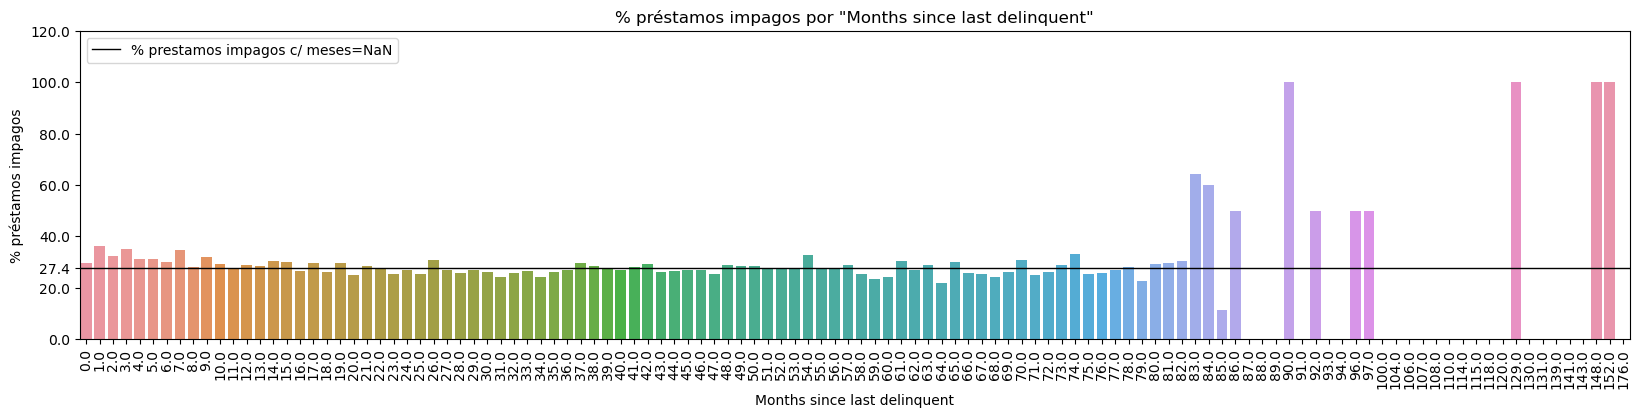

In [51]:
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
plt.axhline(pct_unpaid, color='black', linewidth=1)
plt.legend(["% prestamos impagos c/ meses=NaN"], loc = "upper left")

sns.barplot(x=sorted_months,
            y=defaulted_pcts)

plt.yticks(list(plt.yticks()[0]) + [pct_unpaid])

plt.title('% préstamos impagos por "Months since last delinquent"')
plt.ylabel('% préstamos impagos')
plt.xlabel('Months since last delinquent')

Los registros con valores faltantes tienen una proporción similar de préstamos impagos que los registros con valores presentes.

Los picos al extremo derecho se deben a la poca cantidad de préstamos con esa cantidad de meses desde el último incumplimiento.

Text(0, 0.5, 'Préstamos impagos')

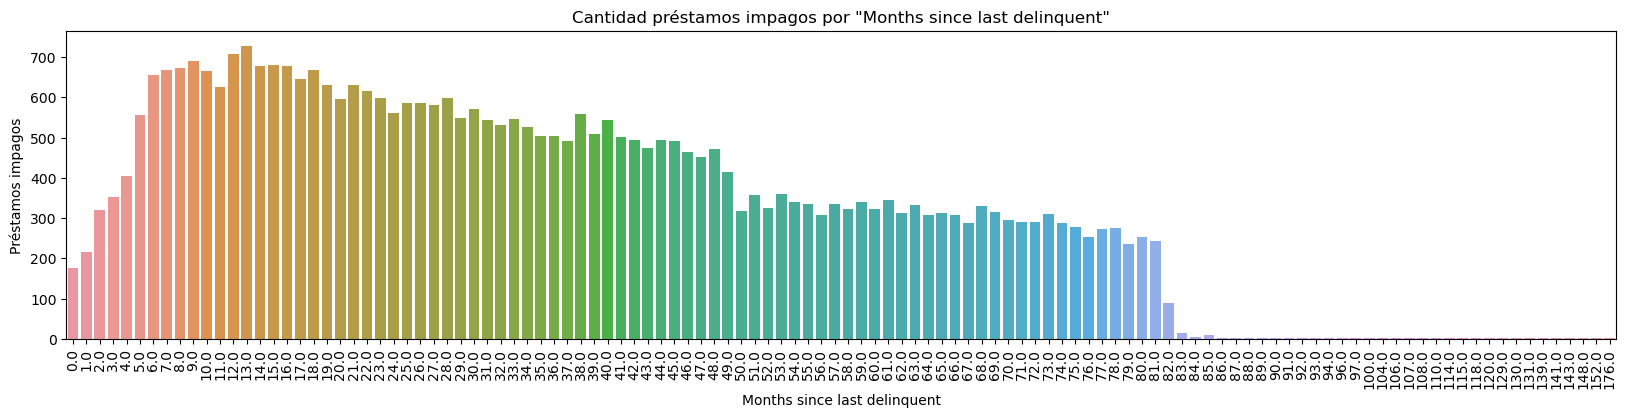

In [52]:
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)

sns.barplot(x=months_feature.value_counts().index,
            y=months_feature.value_counts().values
           )

plt.title('Cantidad préstamos impagos por "Months since last delinquent"')
plt.xlabel('Months since last delinquent')
plt.ylabel('Préstamos impagos')

In [53]:
i = list(sorted_months).index(83)
avg_pct_unpaid = np.mean(defaulted_pcts[:i])

print(f'% de préstamos impagos para registros con valores faltantes en "Months since last delinquent":\n{round(pct_unpaid, 2)}%')
print(f'% promedio de préstamos impagos para registros sin valores faltantes en "Months since last delinquent":\n{round(avg_pct_unpaid, 2)}%')

% de préstamos impagos para registros con valores faltantes en "Months since last delinquent":
27.41%
% promedio de préstamos impagos para registros sin valores faltantes en "Months since last delinquent":
27.82%


Se opta por descartar este predictor ya que tiene demasiados valores faltantes y no guarda gran relación con la variable objetivo.

### 6.2. Credit Score y Annual Income

El cuadro resumen muestra que estas dos carácteristicas tienen la misma cantidad de valores ausentes. Verificar si de hecho se tratan de las mismas observaciones.

In [54]:
is_score_missing = (loans_data['Credit Score'].isna())
is_income_missing = (loans_data['Annual Income'].isna())

loans_data[is_score_missing & is_income_missing].shape[0] == loans_data[is_score_missing].shape[0]

True

Las observaciones sin Credit Score son las mismas que las observaciones sin Annual Income

Una posible explicación para la ausencia simultanea de Puntaje Crediticio **e** Ingresos Anual podría ser que el recipiente del préstamo es una persona joven sin historical crediticio o empleo.

In [55]:
total_obs_no_score = loans_data[is_score_missing].shape[0] * 100
obs_no_score_no_history = loans_data[is_score_missing]['Years of Credit History'].isna().sum()
no_score_no_history_pct = (obs_no_score_no_history / total_obs_no_score) * 100
no_score_no_history_pct = round(no_score_no_history_pct, 2)

print(f'{no_score_no_history_pct}% de las obervaciones sin Credit Score no cuentan con Historial Crediticio')

0.0% de las obervaciones sin Credit Score no cuentan con Historial Crediticio


In [56]:
total_obs_no_income = loans_data[is_income_missing].shape[0] * 100
obs_no_income_no_job = loans_data[is_income_missing]['Years in current job'].isna().sum()
no_income_no_job = (obs_no_income_no_job / total_obs_no_income) * 100
no_income_no_job = round(no_income_no_job, 2)

print(f'{no_income_no_job}% de las obervaciones sin Yearly Income no cuentan con una cantidad de Años en su trabajo actual')

0.04% de las obervaciones sin Yearly Income no cuentan con una cantidad de Años en su trabajo actual


Como se muestra, la ausencia de Puntaje Crediticio no se debe a la ausencia de Historial Crediticio; y la ausencia de Ingreso Anual no se debe a no tener un empleo.

#### 6.2.1. Credit Score

In [57]:
x, y = 'Credit Score', 'Loan Status'

In [58]:
loans_data[x].describe()

count    67052.000000
mean      1153.858408
std       1609.162412
min        585.000000
25%        710.000000
50%        730.000000
75%        743.000000
max       7510.000000
Name: Credit Score, dtype: float64

Un puntaje crediticio promedio esta entre 300 a 850, 800 considerandose excelente. Sin embargo, como se observa, el valor promedio es más de mil, y el valor máximo es de 7500.

In [59]:
descending_scores = loans_data[x].value_counts().sort_index(ascending=False)
descending_scores.head(10)

7510.0     9
7500.0    24
7490.0    23
7480.0    43
7470.0    51
7460.0    76
7450.0    55
7440.0    58
7430.0    70
7420.0    84
Name: Credit Score, dtype: int64

Parece que se agregó un cero de más al final de varios puntajes

In [60]:
list(descending_scores.index)[154:160]

[5890.0, 5860.0, 5850.0, 751.0, 750.0, 749.0]

El puntaje más alto es 751. Valores superiores a 1000 serán divididos entre 10 para eliminar el 0 adicional.

In [61]:
loans_data[x] = loans_data[x].apply(lambda score: score/10 if (score > 999) else score)

In [62]:
loans_data[x].describe()

count    67052.000000
mean       719.602771
std         27.918064
min        585.000000
25%        707.000000
50%        727.000000
75%        740.000000
max        751.000000
Name: Credit Score, dtype: float64

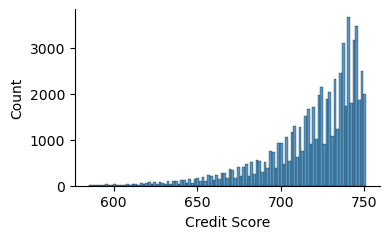

In [63]:
sns.displot(loans_data[x], height=2.5, aspect=1.6)

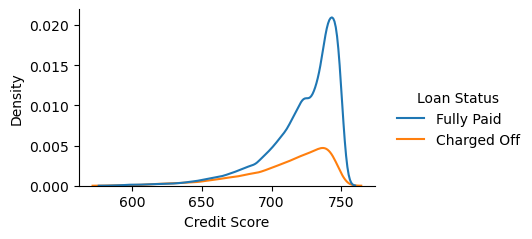

In [64]:
sns.displot(data=loans_data, x=x, hue=y, height=2.5, aspect=1.6, kind='kde')

Se imputaran los valores faltantes con la mediana, ya que la distribución tiende hacia un lado.

In [65]:
median = loans_data[x].median()
loans_data[x].fillna(median,inplace= True)
loans_data[x].isna().sum()

0

#### 6.2.2. Annual Income

In [66]:
x = 'Annual Income'

In [67]:
loans_data[x].describe()

count    6.705200e+04
mean     1.376503e+06
std      1.113132e+06
min      7.662700e+04
25%      8.478608e+05
50%      1.170628e+06
75%      1.649257e+06
max      1.655574e+08
Name: Annual Income, dtype: float64

4 ordenes de magnitud de diferencia entre el valor mínimo y el máximo. Graficar para comprender mejor estos resultados.

<AxesSubplot:xlabel='Annual Income'>

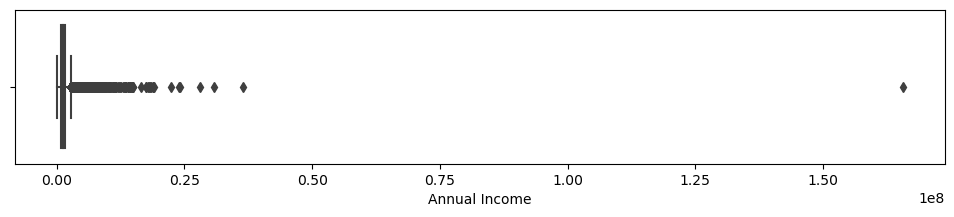

In [68]:
plt.figure(figsize=(12, 2))
sns.boxplot(x=loans_data[x])

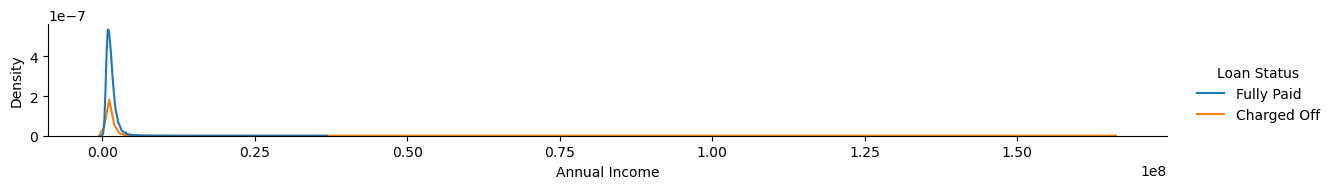

In [69]:
sns.displot(data=loans_data, x=x, hue=y, height=2, aspect=6, kind='kde')

No se utilizará IQR para eliminar valores anómalos en esta columna, ya que no se puede asegurar que sean producto de un error de ingreso de información.

Sin embargo, así se verían los valores si se eliminaran valores anómalos usando IQR.:

<AxesSubplot:xlabel='Annual Income'>

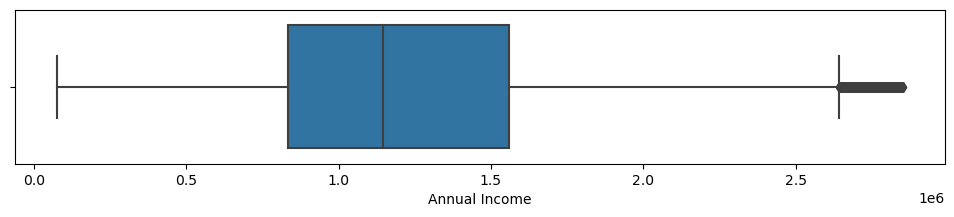

In [70]:
is_annual_income_inlier = is_inside_iqr(loans_data[x])
annual_income_inliers = loans_data[is_annual_income_inlier][x]
plt.figure(figsize=(12, 2))
sns.boxplot(x=annual_income_inliers)

Se imputará usando la mediana porque la distribución es muy inclinada.

In [71]:
median = loans_data[x].median()
loans_data[x].fillna(median, inplace= True)
loans_data[x].isna().sum()

0

### 6.3. Years in current job

In [72]:
x, y = 'Years in current job', 'Loan Status'

In [73]:
graph_df = loans_data.copy()
graph_df[x].fillna('Missing', inplace=True)

In [74]:
order = list(graph_df[x].unique())
order.remove('10+ years')
order.remove('< 1 year')
order.remove('Missing')
order.sort()
order = ['< 1 year'] + order + ['10+ years', 'Missing']

In [75]:
ordered_counts = graph_df[x].value_counts().reindex(order)

Text(0.5, 0, 'Años en su trabajo actual')

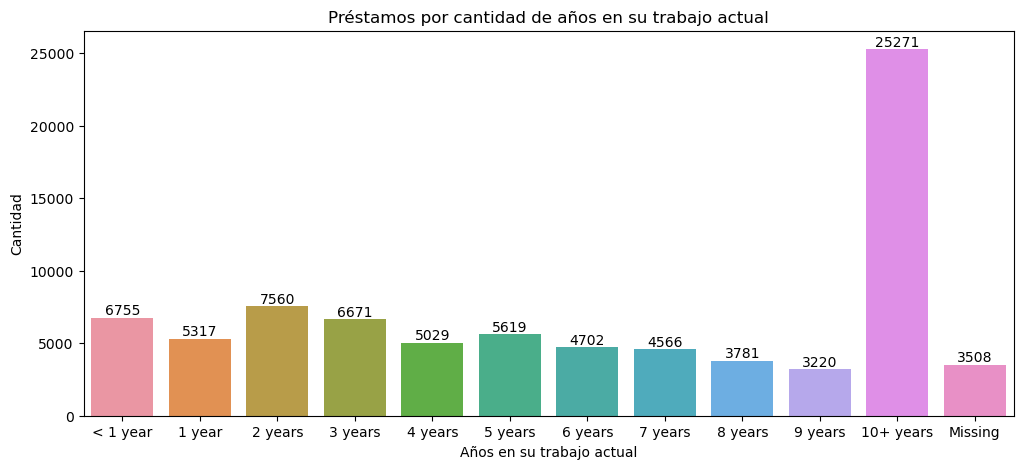

In [76]:
plt.figure(figsize=(12, 5))
x_plot = sns.barplot(x=order, y=ordered_counts)

for container in x_plot.containers:
    x_plot.bar_label(container)

plt.title('Préstamos por cantidad de años en su trabajo actual')
plt.ylabel('Cantidad')
plt.xlabel('Años en su trabajo actual')

Text(0.5, 9.444444444444459, 'Años en su trabajo actual')

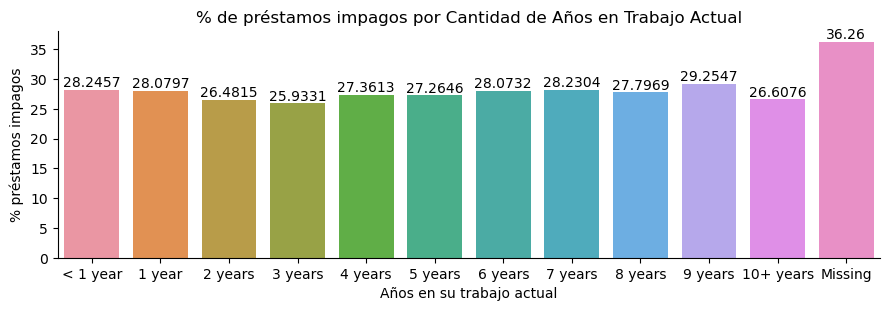

In [77]:
# from stackoverflow.com/questions/34615854/countplot-with-normalized-y-axis-per-group
graph_df = (graph_df
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percent')
            .reset_index()
           )

is_charged_off = (graph_df[y] == 'Charged Off')

graph_df = graph_df[is_charged_off]

x_plot = sns.catplot(data=graph_df, x=x, y='percent', kind='bar', order=order, height=3, aspect=3)

for container in x_plot.ax.containers:
    x_plot.ax.bar_label(container)
    
plt.title('% de préstamos impagos por Cantidad de Años en Trabajo Actual')
plt.ylabel('% préstamos impagos')
plt.xlabel('Años en su trabajo actual')

Es posible que un valor ausente en esta columna signifique que el solicitante se encuentre en un periodo de transición entre empleos.

La distribución de cantidades de préstamos sugeriría utilizar la moda para rellenar los valores faltantes, sin embargo los registros con información faltante tienen un porcentaje de préstamos impagos mayor al promedio, por lo que se les dará su propia categoría: 'Missing' (Faltante/Ausente).

Se realizará una codificación ordinal dandole a los valores faltantes el valor 0, y juntando los periodos "< 1 year" y "1 year"

In [78]:
loans_data[x].fillna('0 years', inplace=True)

In [79]:
import re
dic = {}
for category in loans_data[x].unique():
    years = re.findall(r'\d+', category)
    dic[category] = int(years[0])

In [80]:
loans_data[x] = loans_data[x].map(dic, na_action='ignore')

### 6.4. Bankruptcies

In [81]:
x, y = 'Bankruptcies', 'Loan Status'

In [82]:
loans_data[x].fillna('Missing', inplace=True)

In [83]:
order = list(loans_data[x].value_counts().index)
order.remove('Missing')
order.sort()
order += ['Missing']

Text(0.5, 0, 'Bancarrotas')

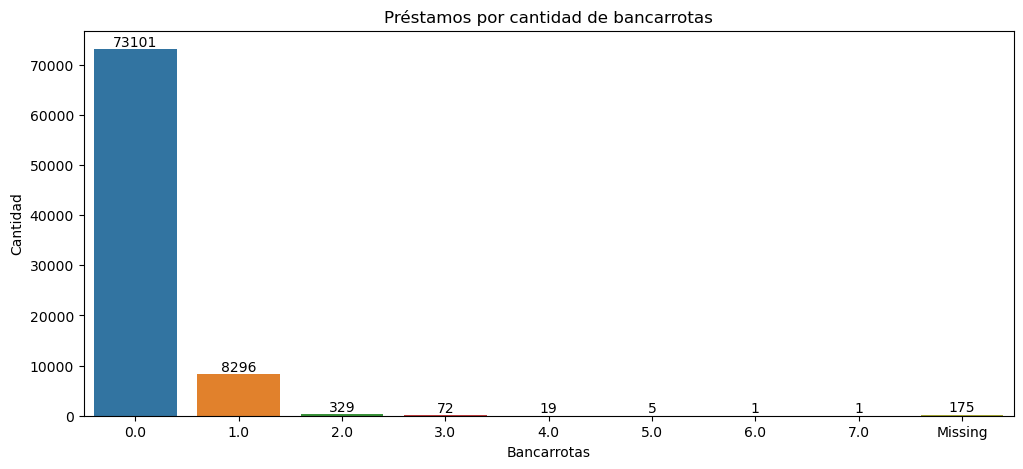

In [84]:
plt.figure(figsize=(12, 5))

ordered_counts = loans_data[x].value_counts().reindex(order)

x_plot = sns.barplot(x=order,
                     y=ordered_counts)

for container in x_plot.containers:
    x_plot.bar_label(container)

plt.title('Préstamos por cantidad de bancarrotas')
plt.ylabel('Cantidad')
plt.xlabel('Bancarrotas')

Los valores faltanes se imputaran con la moda

Text(0.5, 28.999999999999993, 'Bancarrotas')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


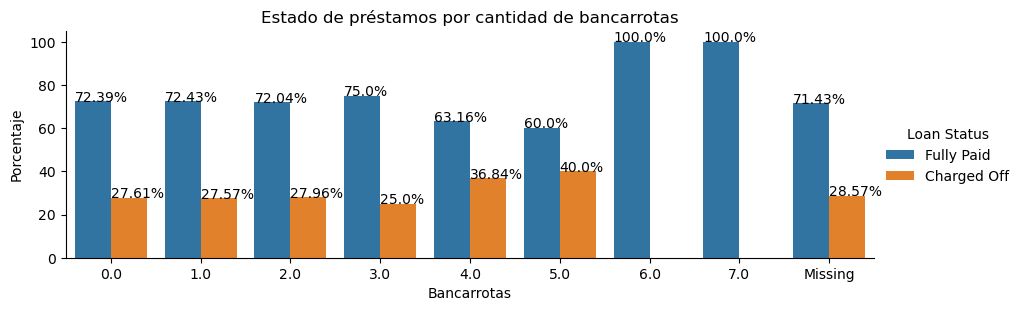

In [85]:
graph_df = (loans_data
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percent')
            .reset_index()
           )

is_charged_off = (graph_df[y] == 'Charged Off')

x_plot = sns.catplot(data=graph_df, x=x, y='percent', hue=y, kind='bar', height=3, aspect=3)

for bar in x_plot.ax.patches:
    txt = str(bar.get_height().round(2)) + '%'
    txt_x = bar.get_x()
    txt_y = bar.get_height()
    x_plot.ax.text(txt_x, txt_y, txt)
    
plt.title('Estado de préstamos por cantidad de bancarrotas')
plt.ylabel('Porcentaje')
plt.xlabel('Bancarrotas')

In [86]:
mode = loans_data[x].mode()[0] # .mode() devuelve una serie
loans_data[x].replace('Missing', mode, inplace=True)
loans_data[x].isna().sum()

0

### 6.5. Tax liens

In [87]:
x, y = 'Tax Liens', 'Loan Status'

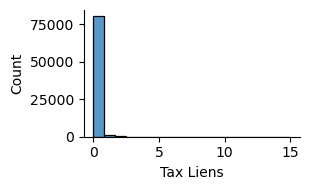

In [88]:
sns.displot(loans_data[x], height=2, aspect=1.6)

Los valores faltanes se imputaran con la moda

Text(0.5, 28.999999999999993, 'Tax Liens')

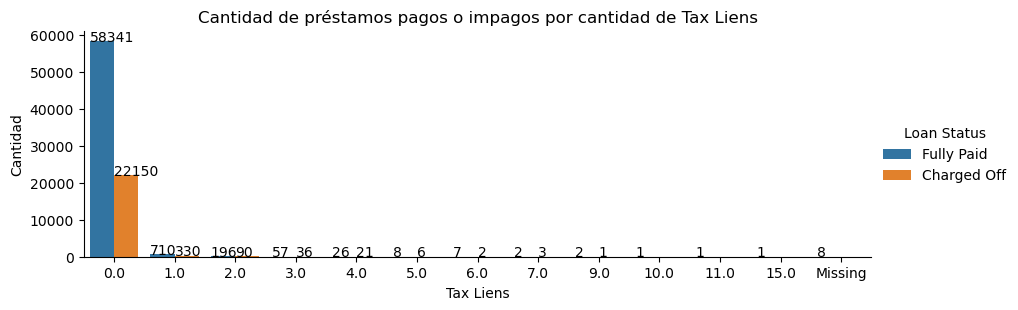

In [89]:
graph_df = loans_data.copy()
graph_df[x].fillna('Missing', inplace=True)

graph_df = (graph_df
            .groupby(x)[y]
            .value_counts(normalize=False)
            .rename('Count')
            .reset_index()
           )

x_plot = sns.catplot(data=graph_df, x=x, y='Count', hue=y, kind='bar', height=3, aspect=3)

for bar in x_plot.ax.patches:
    try:
        txt = str(int(bar.get_height()))
    except:
        continue
    txt_x = bar.get_x()
    txt_y = bar.get_height()
    x_plot.ax.text(txt_x, txt_y, txt)
    
plt.title('Cantidad de préstamos pagos o impagos por cantidad de Tax Liens')
plt.ylabel('Cantidad')
plt.xlabel('Tax Liens')

Text(0.5, 28.999999999999993, 'Tax Liens')

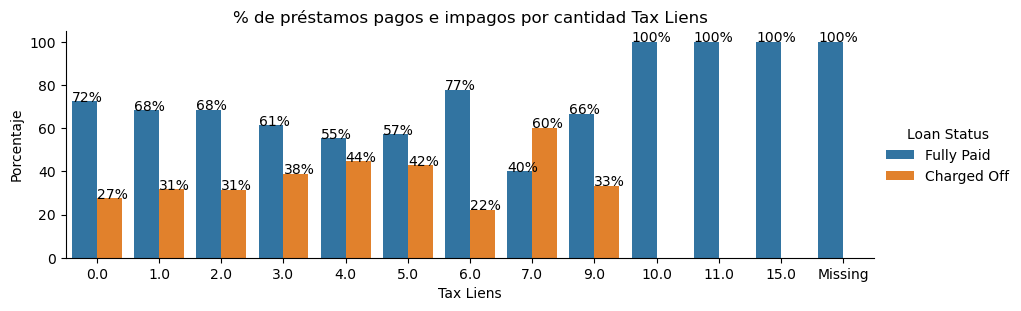

In [90]:
graph_df = loans_data.copy()
graph_df[x].fillna('Missing', inplace=True)

graph_df = (graph_df
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percent')
            .reset_index()
           )

x_plot = sns.catplot(data=graph_df, x=x, y='percent', hue=y, kind='bar', height=3, aspect=3)

for bar in x_plot.ax.patches:
    try:
        txt = str(int(bar.get_height())) + '%'
    except:
        continue
    txt_x = bar.get_x()
    txt_y = bar.get_height()
    x_plot.ax.text(txt_x, txt_y, txt)
    
plt.title('% de préstamos pagos e impagos por cantidad Tax Liens')
plt.ylabel('Porcentaje')
plt.xlabel('Tax Liens')

In [91]:
mode = loans_data[x].mode()[0]
loans_data[x].replace(math.nan, mode, inplace= True)
loans_data[x].isna().sum()

0

### 6.6. Maximum Open Credit

In [92]:
x = 'Maximum Open Credit'

In [93]:
loans_data[x].describe()

count    8.199700e+04
mean     7.935358e+05
std      9.208747e+06
min      0.000000e+00
25%      2.804560e+05
50%      4.777740e+05
75%      7.984900e+05
max      1.539738e+09
Name: Maximum Open Credit, dtype: float64

In [94]:
loans_data[x].value_counts().sort_index().head(5)

0.0       569
4334.0      2
4444.0      1
5390.0      1
6446.0      4
Name: Maximum Open Credit, dtype: int64

500 personas no tienen una cantidad de para su línea de crédito. Se asumirá que esto es un error y se reemplaza con la media.

In [95]:
loans_data[x].nlargest(5)

24955    1.539738e+09
25294    1.304726e+09
67761    9.803053e+08
66770    7.982554e+08
6218     6.324777e+08
Name: Maximum Open Credit, dtype: float64

<AxesSubplot:xlabel='Maximum Open Credit'>

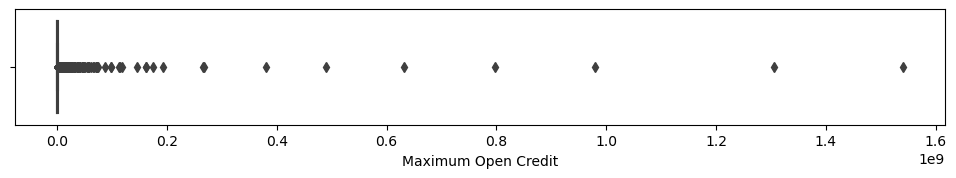

In [96]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(x=loans_data[x])

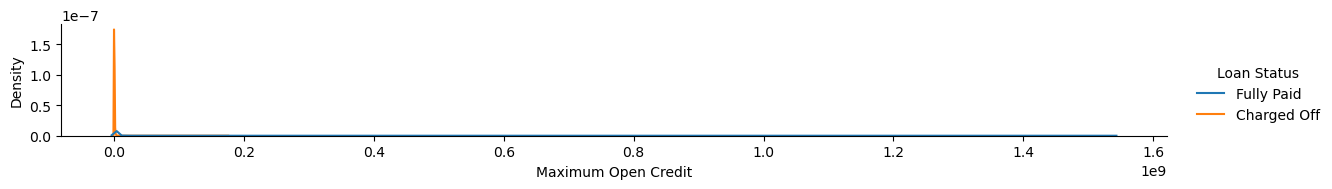

In [97]:
sns.displot(data=loans_data, x=x, hue=y, height=2, aspect=6, kind='kde')

No se utilizará IQR para eliminar valores anómalos en esta columna, ya que no se puede asegurar que sean producto de un error de ingreso de información.

Sin embargo, así se verían los valores si se eliminaran valores anómalos usando IQR.:

<AxesSubplot:xlabel='Maximum Open Credit'>

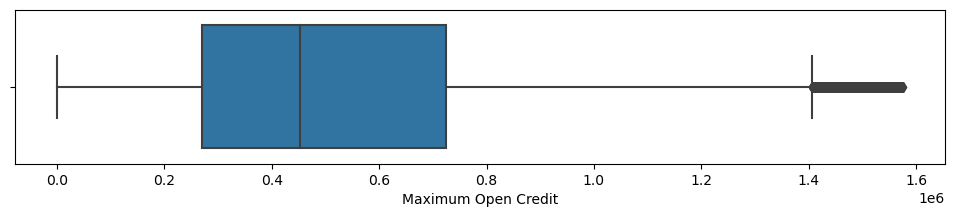

In [98]:
is_max_credit_inlier = is_inside_iqr(loans_data[x])
max_credit_inliers = loans_data[is_max_credit_inlier][x]
plt.figure(figsize=(12, 2))
sns.boxplot(x=max_credit_inliers)

Se imputará usando la mediana porque la distribución es muy inclinada.

In [99]:
median = loans_data[x].median()
loans_data[x].fillna(median,inplace= True)
loans_data[x].isna().sum()

0

### 6.7. Current Loan Amount

In [100]:
x = 'Current Loan Amount'

In [101]:
loans_data[x].describe()

count    8.199900e+04
mean     9.919200e+06
std      2.942401e+07
min      1.080200e+04
25%      1.778040e+05
50%      2.985180e+05
75%      4.837140e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

La media y el percentil 50 tienen 2 ordenes de magnitud de diferencia. Adicionalmente, el valor máximo es bastante elevado, es posible que eso esté causando esta diferencia. Investigar.

In [102]:
loans_data[x].value_counts() \
        .sort_index(ascending=False) \
        .head(4)

99999999.0    7905
789250.0         3
789184.0         4
789096.0        12
Name: Current Loan Amount, dtype: int64

El monto más alto es de 100 millones mientras que el segundo más alto es de solamente 790 mil

In [103]:
loans_data[x].value_counts().head(4)

99999999.0    7905
223322.0        23
214962.0        22
217668.0        21
Name: Current Loan Amount, dtype: int64

La cantidad de prestamos por este monto tambien es desproporcionada

**Asunción**: Se asumirá que un monto de 99 millones es un error.

De momento se cambiará este monto por NaN

In [104]:
loans_data[x].replace(99999999, float("nan"), inplace=True)

In [105]:
loans_data[x].describe()

count     74094.000000
mean     308587.854644
std      183154.097773
min       10802.000000
25%      171974.000000
50%      265672.000000
75%      429792.000000
max      789250.000000
Name: Current Loan Amount, dtype: float64

<AxesSubplot:xlabel='Current Loan Amount'>

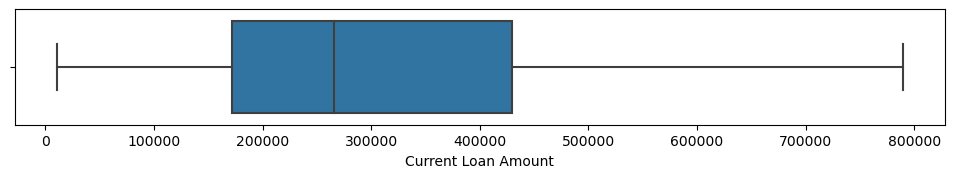

In [106]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(x=loans_data[x])

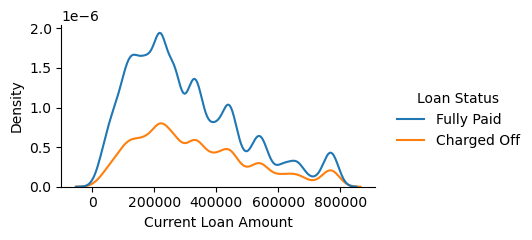

In [107]:
sns.displot(data=loans_data, x=x, hue=y, height=2.5, aspect=1.6, kind='kde')

Se imputaran los valores faltantes con la mediana, ya que la distribución va hacia un lado.

In [108]:
median = loans_data[x].median()
loans_data[x].fillna(median,inplace= True)
loans_data[x].isna().sum()

0

### 6.8. Monthly Debt

In [109]:
x = 'Monthly Debt'

In [110]:
loans_data[x].describe()

count     81999.000000
mean      18330.633110
std       12127.700801
min           0.000000
25%       10117.595000
50%       16075.330000
75%       23811.370000
max      435843.280000
Name: Monthly Debt, dtype: float64

<AxesSubplot:xlabel='Monthly Debt'>

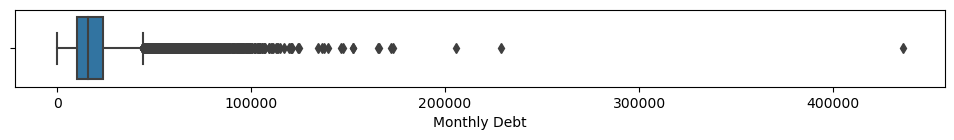

In [111]:
plt.figure(figsize=(12, 1))
sns.boxplot(x=loans_data[x])

Es posible que estos sean datos anomalos naturales. Aun no se tienen motivos para eliminarlos, así que se preservarán.

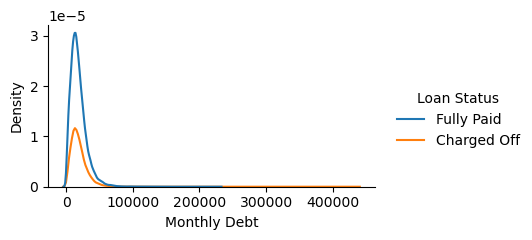

In [112]:
sns.displot(data=loans_data, x=x, hue=y, height=2.5, aspect=1.6, kind='kde')

Sin embargo, así se verían los valores si se eliminaran valores anómalos usando IQR.:

<AxesSubplot:xlabel='Monthly Debt'>

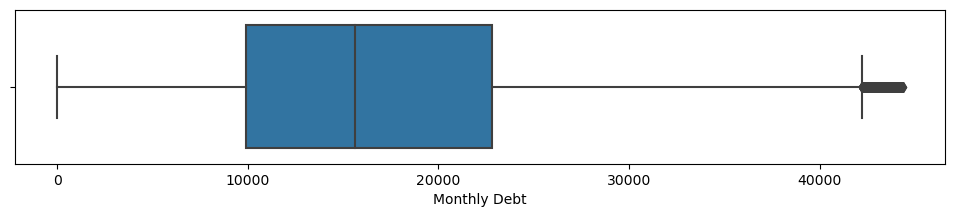

In [113]:
is_monthly_debt_inlier = is_inside_iqr(loans_data[x])
monthly_debt_inliers = loans_data[is_monthly_debt_inlier][x]
plt.figure(figsize=(12, 2))
sns.boxplot(x=monthly_debt_inliers)

### 6.9. Years of Credit History

In [114]:
x = 'Years of Credit History'

In [115]:
loans_data[x].describe()

count    81999.000000
mean        18.296783
std          7.043774
min          3.600000
25%         13.500000
50%         17.000000
75%         21.800000
max         70.500000
Name: Years of Credit History, dtype: float64

<AxesSubplot:xlabel='Years of Credit History'>

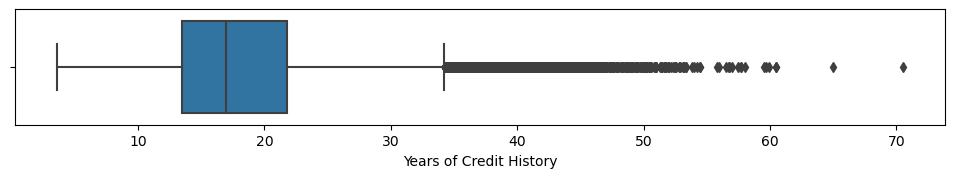

In [116]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(x=loans_data[x])

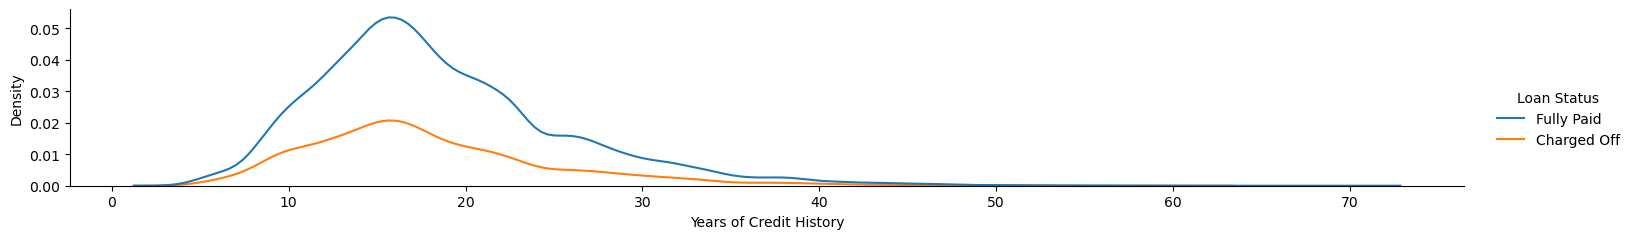

In [117]:
sns.displot(data=loans_data, x=x, hue=y, height=2.5, aspect=6, kind='kde')

Es posible que estos sean datos anomalos naturales. Aun no se tienen motivos para eliminarlos, así que se preservarán.

Sin embargo, así se verían los valores si se eliminaran valores anómalos usando IQR.:

<AxesSubplot:xlabel='Years of Credit History'>

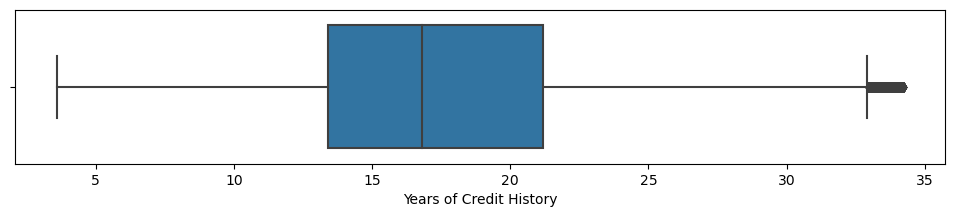

In [118]:
is_credit_years_inlier = is_inside_iqr(loans_data[x])
credit_years_inliers = loans_data[is_credit_years_inlier][x]
plt.figure(figsize=(12, 2))
sns.boxplot(x=credit_years_inliers)

Tomando en cuenta que el historial crediticio empieza alrededor de los 18 años, eliminar valores anómalos en esta variable mediante IQR nos dejaría con observaciones de clientes con una edad máxima de 53 años aproximadamente.

### 6.10. Number of Open Accounts

In [119]:
x = 'Number of Open Accounts'

In [120]:
loans_data[x].describe()

count    81999.000000
mean        11.114489
std          4.981266
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

<AxesSubplot:xlabel='Number of Open Accounts'>

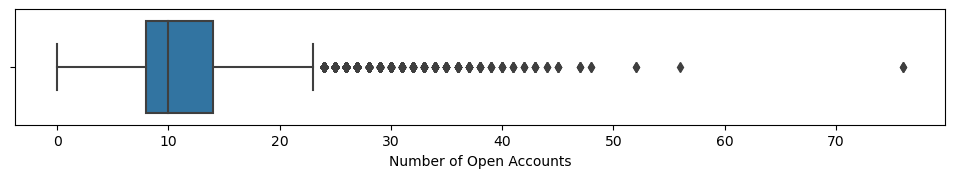

In [121]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(x=loans_data[x])

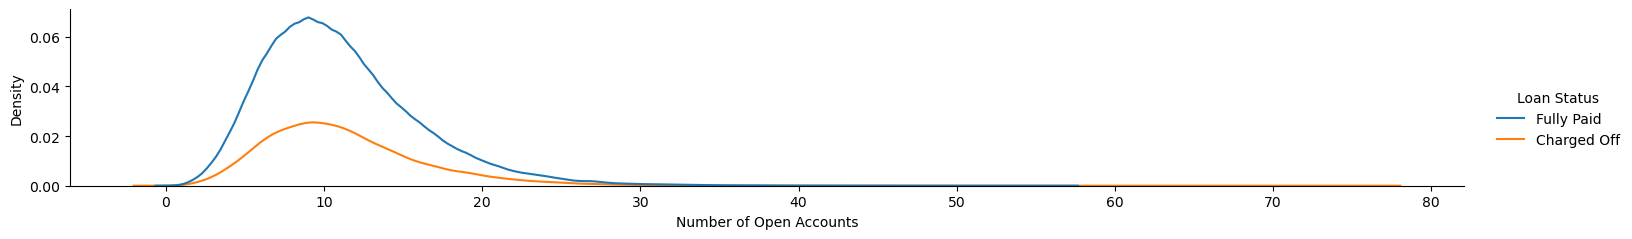

In [122]:
sns.displot(data=loans_data, x=x, hue=y, height=2.5, aspect=6, kind='kde')

Es posible que estos sean datos anomalos naturales. Aun no se tienen motivos para eliminarlos, así que se preservarán.

Sin embargo, así se verían los valores si se eliminaran valores anómalos usando IQR.:

<AxesSubplot:xlabel='Number of Open Accounts'>

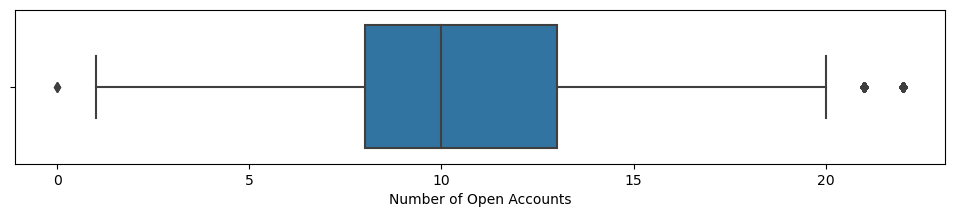

In [123]:
is_number_accounts_inlier = is_inside_iqr(loans_data[x])
number_accounts_inliers = loans_data[is_number_accounts_inlier][x]
plt.figure(figsize=(12, 2))
sns.boxplot(x=number_accounts_inliers)

Text(0.5, 9.444444444444459, 'Número de cuentas abiertas')

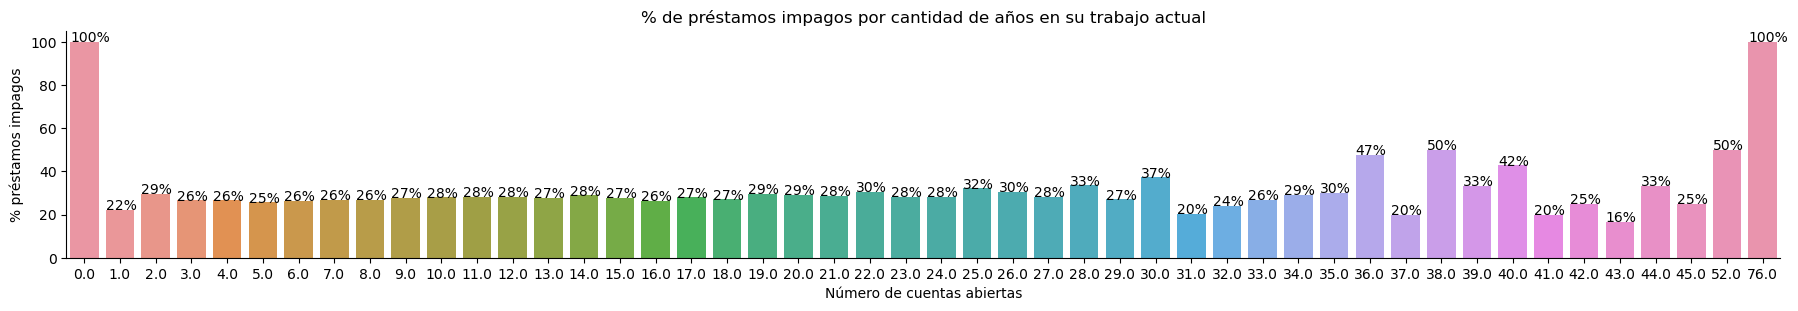

In [124]:
x, y = 'Number of Open Accounts', 'Loan Status'

graph_df = loans_data.copy()
graph_df[x].fillna('Missing', inplace=True)

graph_df = (graph_df
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percent')
            .reset_index()
           )

is_charged_off = (graph_df[y] == 'Charged Off')

graph_df = graph_df[is_charged_off]

job_years_plot = sns.catplot(data=graph_df, x=x, y='percent', kind='bar', height=3, aspect=6)

for bar in job_years_plot.ax.patches:
    txt = str(int(bar.get_height())) + '%'
    txt_x = bar.get_x()
    txt_y = bar.get_height()
    job_years_plot.ax.text(txt_x, txt_y, txt)
    
plt.title('% de préstamos impagos por cantidad de años en su trabajo actual')
plt.ylabel('% préstamos impagos')
plt.xlabel('Número de cuentas abiertas')

### 6.11. Number of Credit Problems

In [125]:
x = 'Number of Credit Problems'

In [126]:
loans_data[x].describe()

count    81999.000000
mean         0.161441
std          0.473148
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Number of Credit Problems, dtype: float64

Text(0.5, 0, 'Problemas de Crédito')

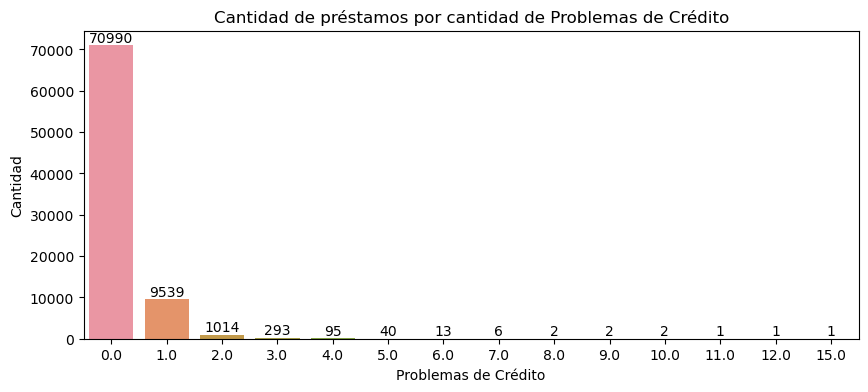

In [127]:
x = loans_data['Number of Credit Problems'].value_counts().index
y = loans_data['Number of Credit Problems'].value_counts().values

plt.figure(figsize=(10, 4))
credit_problems_plot = sns.barplot(x=x, y=y)

for container in credit_problems_plot.containers:
    credit_problems_plot.bar_label(container)
    
plt.title('Cantidad de préstamos por cantidad de Problemas de Crédito')
plt.ylabel('Cantidad')
plt.xlabel('Problemas de Crédito')

Text(0.5, 9.444444444444459, 'Número de problemas de crédito')

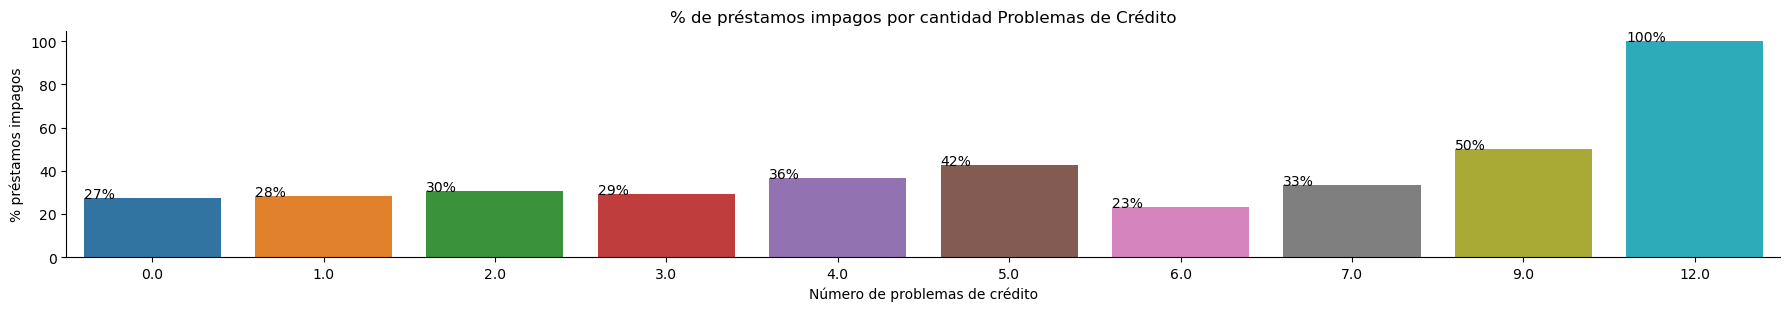

In [128]:
x, y = 'Number of Credit Problems', 'Loan Status'

graph_df = loans_data.copy()
graph_df[x].fillna('Missing', inplace=True)

graph_df = (graph_df
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percent')
            .reset_index()
           )

is_charged_off = (graph_df[y] == 'Charged Off')

graph_df = graph_df[is_charged_off]

job_years_plot = sns.catplot(data=graph_df, x=x, y='percent', kind='bar', height=3, aspect=6)

for bar in job_years_plot.ax.patches:
    txt = str(int(bar.get_height())) + '%'
    txt_x = bar.get_x()
    txt_y = bar.get_height()
    job_years_plot.ax.text(txt_x, txt_y, txt)
    
plt.title('% de préstamos impagos por cantidad Problemas de Crédito')
plt.ylabel('% préstamos impagos')
plt.xlabel('Número de problemas de crédito')

### 6.12. Current Credit Balance

In [129]:
x = 'Current Credit Balance'

In [130]:
loans_data[x].describe()

count    8.199900e+04
mean     2.936203e+05
std      3.726145e+05
min      0.000000e+00
25%      1.133160e+05
50%      2.099310e+05
75%      3.669945e+05
max      3.287897e+07
Name: Current Credit Balance, dtype: float64

<AxesSubplot:xlabel='Current Credit Balance'>

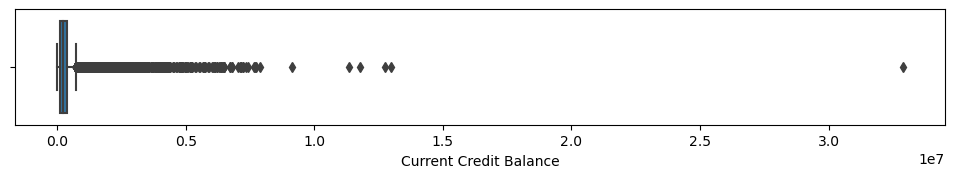

In [131]:
plt.figure(figsize=(12, 1.5))
sns.boxplot(x=loans_data[x])

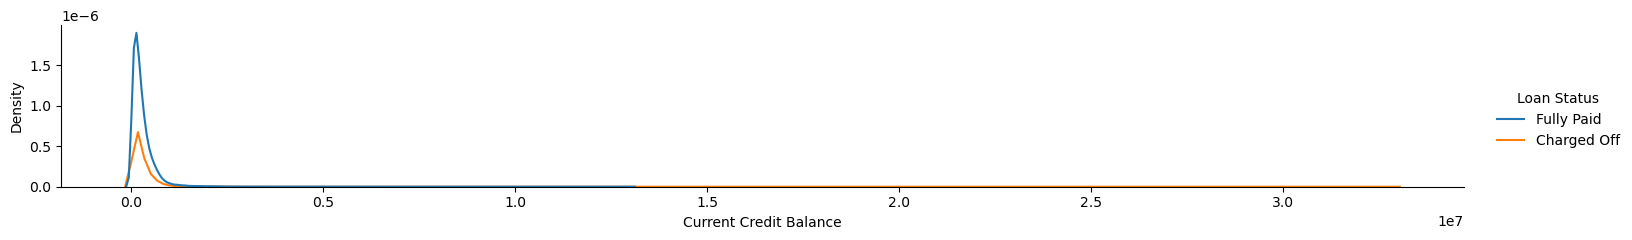

In [132]:
sns.displot(data=loans_data, x=x, hue=y, height=2.5, aspect=6, kind='kde')

Es posible que estos sean datos anomalos naturales. Aun no se tienen motivos para eliminarlos, así que se preservarán.

Sin embargo, así se verían los valores si se eliminaran valores anómalos usando IQR.:

<AxesSubplot:xlabel='Current Credit Balance'>

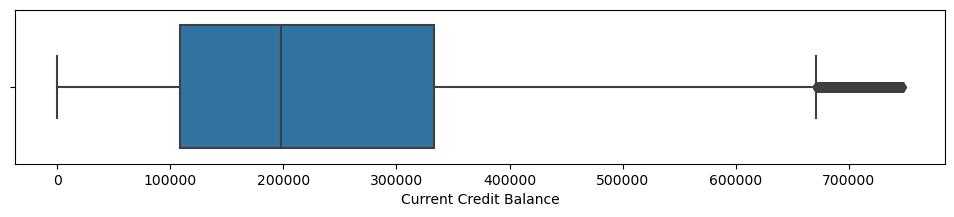

In [133]:
is_credit_balance_inlier = is_inside_iqr(loans_data[x])
credit_balance_inliers = loans_data[is_credit_balance_inlier][x]
plt.figure(figsize=(12, 2))
sns.boxplot(x=credit_balance_inliers)

### 6.13. Sin valores anómalos

In [134]:
loans_data_backup_6 = loans_data.copy()

In [135]:
loans_data = loans_data_backup_6.copy() #checkpoint

## 7. Codificación de variables categóricas <a name="7"></a>

En esta sección se explorarán las variables categóricas restantes y se codificarán

### 7.1. Home Ownership

Text(0.5, 0, 'Home Ownership')

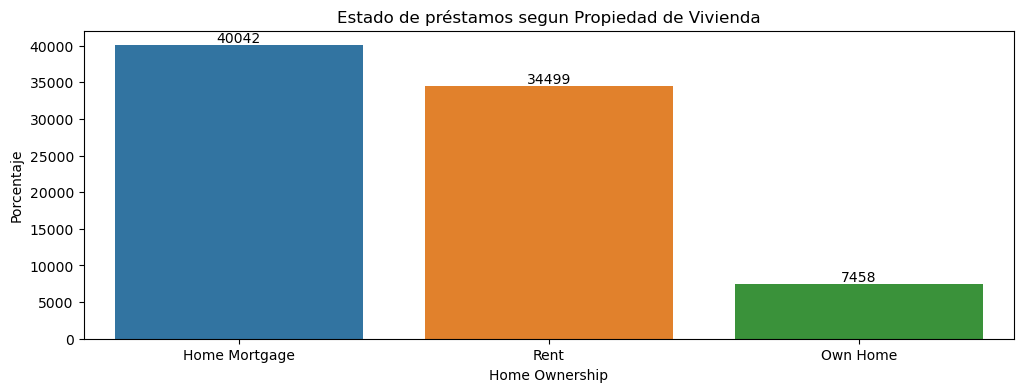

In [136]:
x, y = 'Home Ownership', 'Loan Status'

plt.figure(figsize=(12, 4))
x_plot = sns.barplot(x=loans_data[x].value_counts().index,
                     y=loans_data[x].value_counts().values
                    )

for container in x_plot.containers:
    x_plot.bar_label(container)
    
plt.title('Estado de préstamos segun Propiedad de Vivienda')
plt.ylabel('Porcentaje')
plt.xlabel('Home Ownership')

Text(0.5, 28.999999999999993, 'Home Ownership')

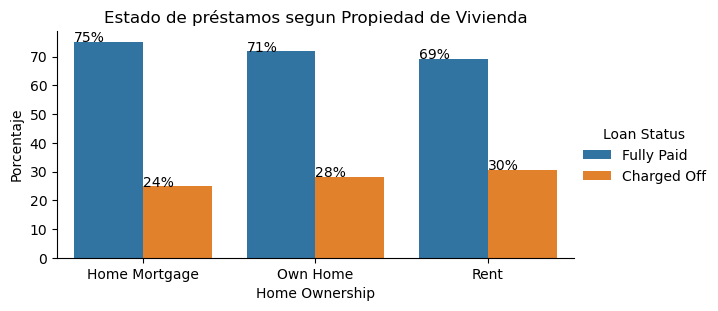

In [137]:
graph_df = (loans_data
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percent')
            .reset_index()
           )

x_plot = sns.catplot(data=graph_df, x=x, y='percent', hue=y, kind='bar', height=3, aspect=2)

for bar in x_plot.ax.patches:
    txt = str(int(bar.get_height())) + '%'
    txt_x = bar.get_x()
    txt_y = bar.get_height()
    x_plot.ax.text(txt_x, txt_y, txt)
    
plt.title('Estado de préstamos segun Propiedad de Vivienda')
plt.ylabel('Porcentaje')
plt.xlabel('Home Ownership')

Se usará codificación ordinal ya que se aprecia que a menor grado de propiedad sobre una vivienda mayor porcentaje de préstamos impagos.

In [138]:
dic = {"Home Mortgage": 2,
       "Own Home": 1,
       "Rent": 0
      }
loans_data[x] = loans_data[x].map(dic, na_action='ignore')

### 7.2. Purpose

Text(0.5, 0, 'Propósito')

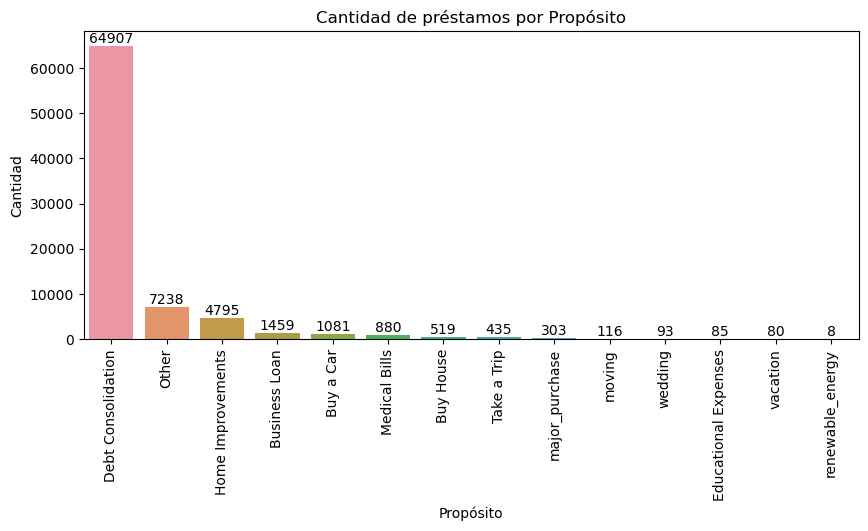

In [139]:
x, y = 'Purpose', 'Loan Status'

plt.figure(figsize=(10, 4))
x_plot = sns.barplot(x=loans_data[x].value_counts().index,
                     y=loans_data[x].value_counts().values
                    )

for container in x_plot.containers:
    x_plot.bar_label(container)
    
plt.xticks(rotation=90)
plt.title('Cantidad de préstamos por Propósito')
plt.ylabel('Cantidad')
plt.xlabel('Propósito')

Text(0.5, 29.0, 'Home Ownership')

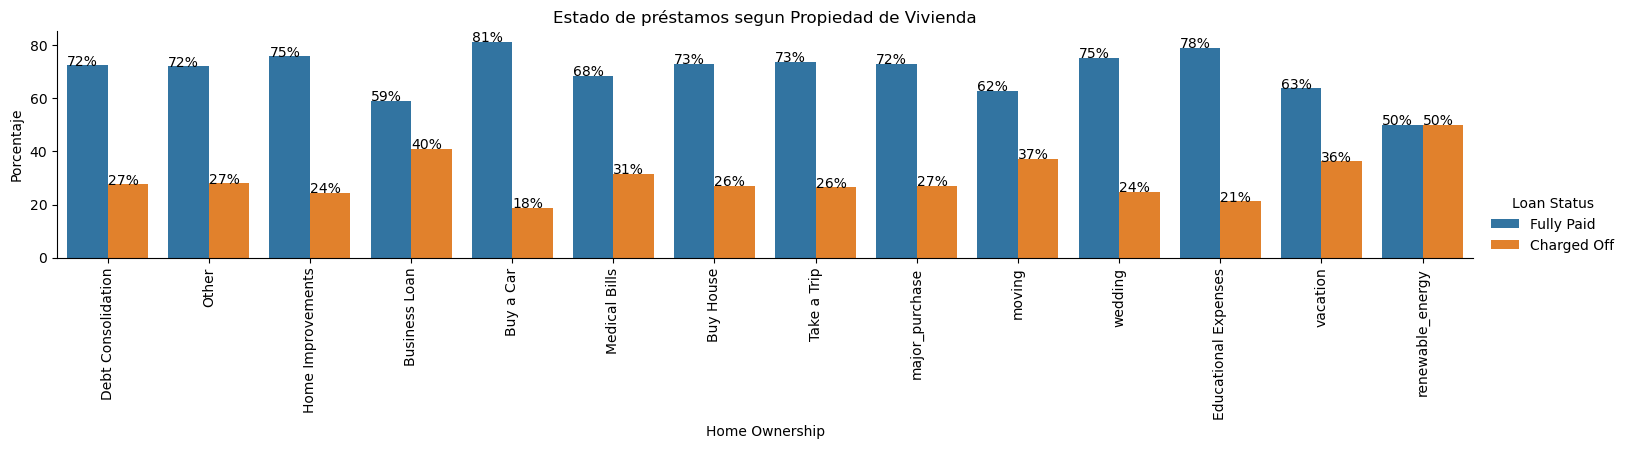

In [140]:
graph_df = (loans_data
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percent')
            .reset_index()
           )

x_plot = sns.catplot(data=graph_df, x=x, y='percent', hue=y, order=loans_data[x].value_counts().index, kind='bar', height=3, aspect=5)

for bar in x_plot.ax.patches:
    txt = str(int(bar.get_height())) + '%'
    txt_x = bar.get_x()
    txt_y = bar.get_height()
    x_plot.ax.text(txt_x, txt_y, txt)
    
plt.xticks(rotation=90)
plt.title('Estado de préstamos segun Propiedad de Vivienda')
plt.ylabel('Porcentaje')
plt.xlabel('Home Ownership')

Hay algunas categorias con porcentaje de préstamos impagos mayores que el resto, como 'Business Loan', 'Medical Bills', 'Moving' y 'vacation', sin embargo no hay un orden claro, por lo que se utilizará codificación one-hot.

In [141]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

ohe_cols = pd.DataFrame(ohe.fit_transform(loans_data[[x]]))
ohe_cols.index = loans_data.index

loans_data = loans_data.drop(x, axis=1)
loans_data = pd.concat([loans_data, ohe_cols], axis=1)

### 7.3. Term

Text(0.5, 0, 'Termino')

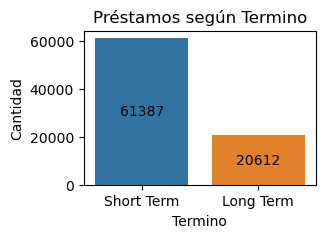

In [142]:
x, y = 'Term', 'Loan Status'

plt.figure(figsize=(3, 2))
x_plot = sns.barplot(x=loans_data[x].value_counts().index,
                     y=loans_data[x].value_counts().values
                    )

for container in x_plot.containers:
    x_plot.bar_label(container, label_type='center')
    
plt.title('Préstamos según Termino')
plt.ylabel('Cantidad')
plt.xlabel('Termino')

Text(0.5, 29.000000000000007, 'Termino')

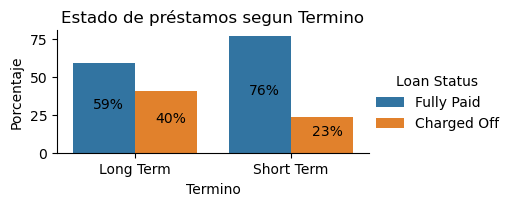

In [143]:
graph_df = (loans_data
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('percent')
            .reset_index()
           )

x_plot = sns.catplot(data=graph_df, x=x, y='percent', hue=y, kind='bar', height=2, aspect=2)

for bar in x_plot.ax.patches:
    txt = str(int(bar.get_height())) + '%'
    bar_w = bar.get_width()
    txt_x = bar.get_x() + bar_w / 3
    txt_y = bar.get_height() / 2
    x_plot.ax.text(txt_x, txt_y, txt)

plt.title('Estado de préstamos segun Termino')
plt.ylabel('Porcentaje')
plt.xlabel('Termino')

Los préstamos con términos largos son mucho más riesgosos que que los préstamos a corto plazo. Se usará codificación ordinal.

In [144]:
dic = {"Long Term": 0,
       "Short Term": 1,
      }
loans_data[x] = loans_data[x].map(dic, na_action='ignore')

### 7.4. Variable objetivo: Loan Status

In [145]:
x = 'Loan Status'

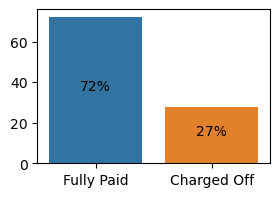

In [146]:
plt.figure(figsize=(3, 2))
x_plot = sns.barplot(x=loans_data[x].value_counts().index,
            y=loans_data[x].value_counts().values / loans_data.shape[0] * 100
           )

for bar in x_plot.patches:
    txt = str(int(bar.get_height())) + '%'
    bar_w = bar.get_width()
    txt_x = bar.get_x() + bar_w / 3
    txt_y = bar.get_height() / 2
    x_plot.text(txt_x, txt_y, txt)

Como se observa, la mayoría de los préstamos terminan en pago, por  lo que se trata de un problema de clasificación binaria imbalanceado. Por tratarse de préstamos, se asignará "1" a los préstamos impagos, ya que es deseable poder identificar estos y minimizar perdidas.

In [147]:
dic = {"Fully Paid": 0,
       "Charged Off": 1,
      }
loans_data[x] = loans_data[x].map(dic, na_action='ignore')

In [148]:
backup_7 = loans_data.copy()

In [149]:
loans_data = backup_7.copy() #checkpoint

## 8. Mátriz de Correlación <a name="8"></a>
Una vez que todas las columnas tienen valores númericos es posible crear una mátriz de correlación. Se descartarón las columnas de codificación one-hot para ayudar a la visualización.

<AxesSubplot:>

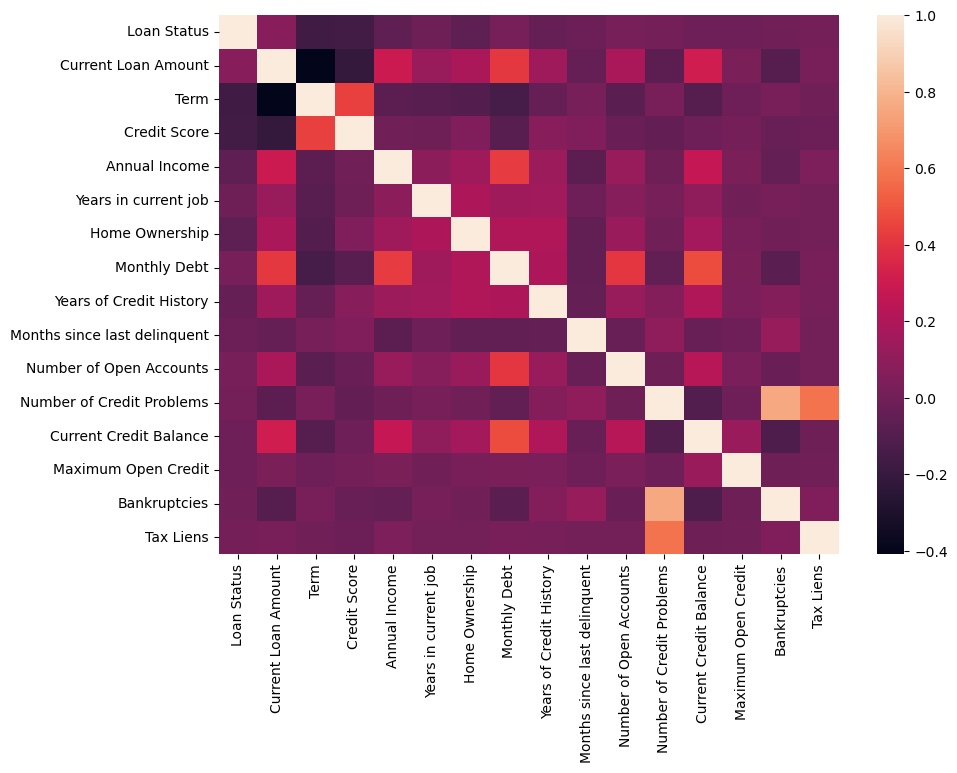

In [151]:
corr_data = loans_data.drop(ohe_cols.columns, axis=1)
plt.figure(figsize=(10,7))
sns.heatmap(corr_data.corr(), annot= False)

## 9. Creación de modelos <a name="9"></a>

Se buscará crear modelos que reduzcan la cantidad de Impagos (27%)

**Sets de entrenamiento y de prueba**

Se descartan las columnas Loan ID y Customer ID por ser de identificación, y se como se mencionó anteriormente, se descarta la columna de "Months since last delinquent".

80% de los registros serán usados para entrenamiento y el 20% restante se usarán para prueba.

In [152]:
loans_data.drop(['Loan ID', 'Customer ID', 'Months since last delinquent'], axis=1, inplace=True)

In [153]:
loans_data.columns = loans_data.columns.astype(str) # OHE devuelve columnas con nombres númericos
                                                    # eso puede causar problemas
x = loans_data.drop(['Loan Status'], axis=1)
y = loans_data['Loan Status']

In [154]:
from sklearn.model_selection import train_test_split

splits = train_test_split(x, y, train_size=0.8, shuffle=True, random_state=1)
train_x, train_y = splits[0], splits[2]
remain_x, remain_y = splits[1], splits[3]

splits = train_test_split(remain_x, remain_y, train_size=0.5, shuffle=True, random_state=1)
test_x, test_y = splits[0], splits[2]
validation_x, validation_y = splits[1], splits[3]

### 9.1. Modelo 1: Bosque aleatorio con datos anómalos <a name="91"></a>

Se usará un modelo de Bosques Aleatorios ya que no se han estandarizado los datos y no se eliminaron datos anómalos.

In [155]:
from sklearn.ensemble import RandomForestClassifier

model_1 = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model_1.fit(train_x, train_y)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [156]:
predictions_1 = model_1.predict(test_x)

#### 9.1.1. Evaluación del modelo

In [157]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                                display_labels=[False, True],
                                               )

    cm_display.plot()

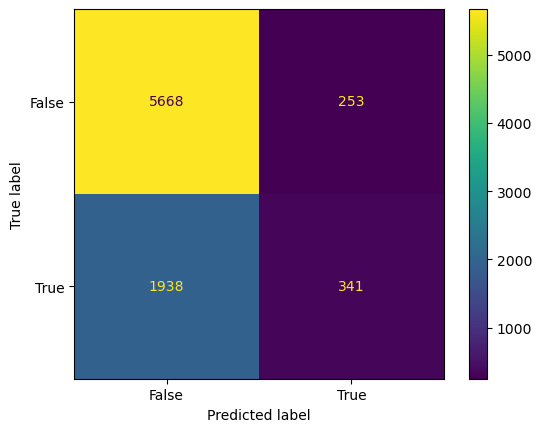

In [158]:
plot_confusion_matrix(test_y, predictions_1)

In [159]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def print_metrics(true_y, predictions):
    accuracy = accuracy_score(true_y, predictions) * 100
    precision = precision_score(true_y, predictions) * 100
    recall = recall_score(true_y, predictions) * 100
    specificity = recall_score(true_y, predictions, pos_label=0) * 100

    print(f'Exactitud: {round(accuracy, 2)}%')
    print(f'Precisión: {round(precision, 2)}%')
    print(f'Exhaustividad (TPR): {round(recall, 2)}%')
    print(f'Especificidad: {round(specificity, 2)}%' + f' (FPR: {round(100 - specificity, 2)}%)')
    
    return [accuracy, precision, recall, specificity]

In [160]:
metrics_1 = print_metrics(test_y, predictions_1)

Exactitud: 73.28%
Precisión: 57.41%
Exhaustividad (TPR): 14.96%
Especificidad: 95.73% (FPR: 4.27%)


Se obtiene un modelo bueno prediciendo pagos (Especificidad) y malo prediciendo impagos (Exhaustividad), lo cual es lo opuesto de lo que se busca detectar.

Tambien hay que tomar en cuenta el imbalance entre préstamos que resultaron en pago (72%) y los préstamos que resultaron en impago (27%). Por esta razón, otra métrica útil sería el Área bajo la curva ROC.

Similarmente, debido al imbalance, no debería darsele mucha atención a Exactitud.

In [161]:
from sklearn.metrics import roc_auc_score

def print_roc(test_x, test_y, model):
    score_y = model.predict_proba(test_x)[:, 1]
    roc = roc_auc_score(test_y, score_y)
    roc = round(roc, 3)

    print(f'Área bajo la ROC: {roc}')
    
    return roc

In [162]:
roc_1 = print_roc(test_x, test_y, model_1)

Área bajo la ROC: 0.709


Este valor indica que el modelo podría tener un desempeño aceptable como clasificador.

#### 9.1.2. Mejora del modelo

Para cada registro, el modelo calcula una probabilidad de que ese registro pertenezca a la clase 1 (Impago) o 0 (Pago). Valores por encima del umbral de 0.5 (valor por defecto) son clasificados con la clase 1. Se utilizará la ROC para encontrar un umbral que brinde un nivel de Exhaustividad deseado.

In [163]:
from sklearn.metrics import roc_curve, auc

def plot_roc(test_x, test_y, model):
    score_y = model.predict_proba(test_x)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_y, score_y)

    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic - LReg (All features)')
    plt.plot(fpr, tpr, 'b',
             label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0,1.0])
    plt.ylim([-0,1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return fpr, tpr, thresholds

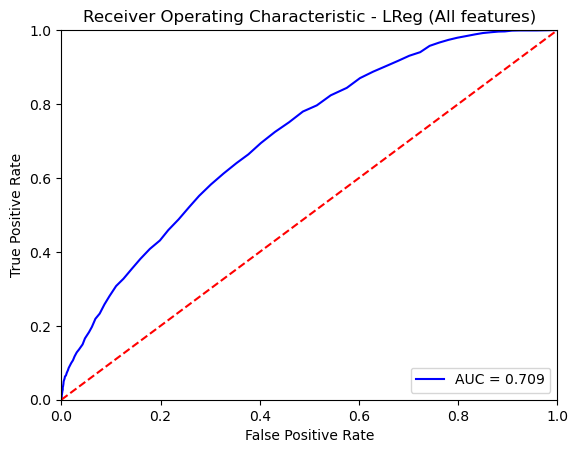

In [164]:
fpr, tpr, thresholds = plot_roc(test_x, test_y, model_1)

Como se aprecia, incrementos en la Exhaustividad (TPR) significan incrementos en la FPR, osea declinar préstamos erroneamente por considerarlos inseguros. Para evitar declinar demasiados préstamos, se apuntará a una Exhaustividad (TPR) conservadora de >=0.77 (23% de impago).

In [165]:
target_tpr = 0.77
index_target_tpr = np.where(tpr >= target_tpr)[0][0]
threshold_1 = thresholds[index_target_tpr]

print(f'El umbral deseado es de {threshold_1}')

El umbral deseado es de 0.26


**Verificación**

In [166]:
predictions_1 = model_1.predict_proba(test_x)[:, 1]
predictions_1[predictions_1 >= threshold_1] = 1
predictions_1[predictions_1 < threshold_1] = 0

In [167]:
metrics_1 = print_metrics(test_y, predictions_1)

Exactitud: 58.72%
Precisión: 38.13%
Exhaustividad (TPR): 77.97%
Especificidad: 51.31% (FPR: 48.69%)


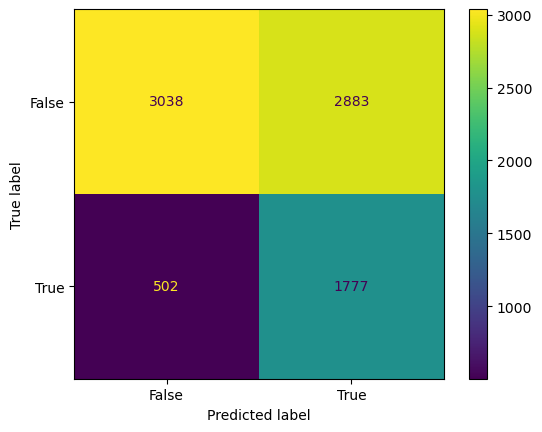

In [168]:
plot_confusion_matrix(test_y, predictions_1)

Como se aprecia, con un umbral más bajo, se hace que el modelo clasifique más observaciones como Impagos.

In [169]:
def train_and_optimize_model(model, train_x, train_y, test_x, test_y, target_tpr):
    
    # entrenar modelo
    model.fit(train_x, train_y)
    
    # generar predicciones y probabilidades
    predictions = model.predict(test_x)
    probabilities = model.predict_proba(test_x)[:, 1]
    
    # obtener metricas
    print('Metricas iniciales:')
    metrics = print_metrics(test_y, predictions)
    roc = roc_auc_score(test_y, probabilities)
    roc = round(roc, 3)
    
    # valores roc
    fpr, tpr, thresholds = plot_roc(test_x, test_y, model)
    
    # encontrar umbral que alcanza TPR objetivo
    target_tpr_index = np.where(tpr >= target_tpr)[0][0]
    needed_threshold = thresholds[target_tpr_index]
    
    # clasificar predicciones de acuerdo al umbral obtenido
    optimized_predictions = probabilities.copy()
    optimized_predictions[optimized_predictions >= needed_threshold] = 1
    optimized_predictions[optimized_predictions < needed_threshold] = 0
    
    print('\nMetricas con TPR objetivo:')
    print(f"Umbral: {needed_threshold}")
    metrics = print_metrics(test_y, optimized_predictions)
    plot_confusion_matrix(test_y, optimized_predictions)
    
    return model, metrics, needed_threshold, roc

### 9.2. Modelo 2: Modelo 1 con menos predictores (Feature Importances) <a name="92"></a>

**Calcular importancia de los predictores**

In [170]:
def plot_feature_importance(model, x):
    plt.figure(figsize=(4, 7))
    feature_importance = model.feature_importances_
    var_imp = pd.DataFrame({'feature':x.columns.tolist(), 
                            'importance':feature_importance})
    var_imp = var_imp.sort_values(ascending=False, 
                                  by='importance')
    sns.barplot(x='importance', 
                     y='feature', 
                     data=var_imp)

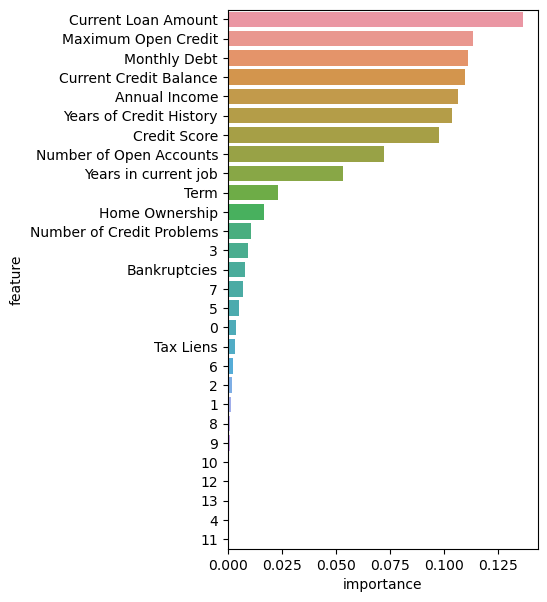

In [171]:
plot_feature_importance(model_1, x)

**Selección de predictores**

In [172]:
i = np.where(x.columns == 'Home Ownership')[0][0] # escogido subjetivamente

In [173]:
importance_threshold = model_1.feature_importances_[i]

In [174]:
from sklearn.feature_selection import SelectFromModel

is_importante_enough = SelectFromModel(model_1, threshold=importance_threshold)
is_importante_enough.fit(train_x, train_y)

fi_top_features = train_x.columns[(is_importante_enough.get_support())]
fi_top_features = fi_top_features.tolist()

**Modelo con los predictores seleccionados**

Metricas iniciales:
Exactitud: 73.45%
Precisión: 57.8%
Exhaustividad (TPR): 16.59%
Especificidad: 95.34% (FPR: 4.66%)

Metricas con TPR objetivo:
Umbral: 0.25
Exactitud: 56.39%
Precisión: 36.6%
Exhaustividad (TPR): 77.71%
Especificidad: 48.18% (FPR: 51.82%)


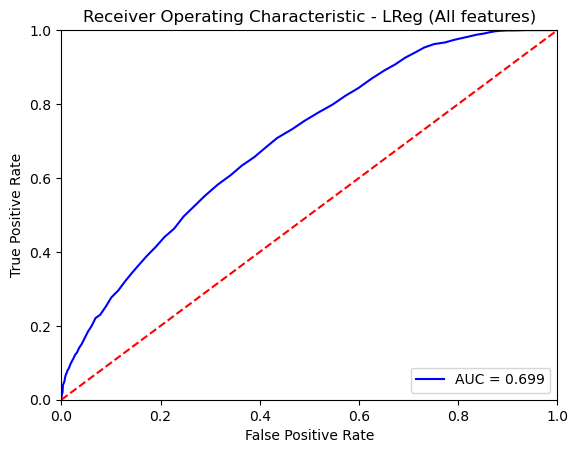

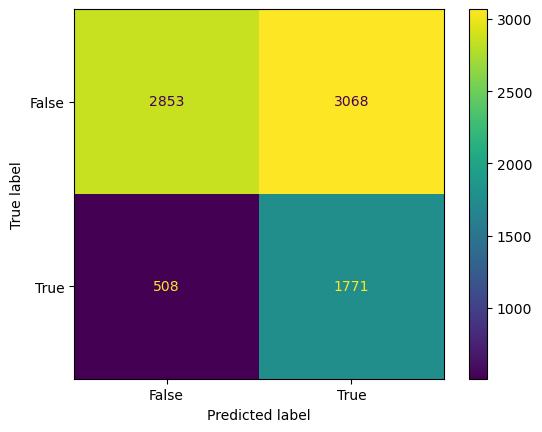

In [175]:
model_2 = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model_2, metrics_2, threshold_2, roc_2 = train_and_optimize_model(
                                                                    model_2,
                                                                    train_x[fi_top_features], train_y,
                                                                    test_x[fi_top_features], test_y,
                                                                    target_tpr
                                                                )

### 9.3. Modelo 3: Modelo 1 con menos predictores (Permutation Importance) <a name="93"></a>

In [176]:
import eli5
from eli5.sklearn import PermutationImportance

In [177]:
perm_imp = PermutationImportance(model_1, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm_imp, feature_names = train_x.columns.tolist())

Weight,Feature
0.0176 ± 0.0030,Term
0.0104 ± 0.0028,Annual Income
0.0072 ± 0.0026,Current Loan Amount
0.0069 ± 0.0034,Maximum Open Credit
0.0047 ± 0.0036,Credit Score
0.0035 ± 0.0025,Current Credit Balance
0.0005 ± 0.0007,0
0.0004 ± 0.0012,3
0.0003 ± 0.0002,2
0.0002 ± 0.0010,7


In [178]:
pi_top_features = eli5.explain_weights_df(perm_imp, feature_names = train_x.columns.tolist())
pi_top_features = pi_top_features.loc[pi_top_features['weight'] >= 0.004]['feature'].tolist()

Metricas iniciales:
Exactitud: 71.44%
Precisión: 46.96%
Exhaustividad (TPR): 21.33%
Especificidad: 90.73% (FPR: 9.27%)

Metricas con TPR objetivo:
Umbral: 0.21
Exactitud: 52.63%
Precisión: 34.44%
Exhaustividad (TPR): 77.97%
Especificidad: 42.88% (FPR: 57.12%)


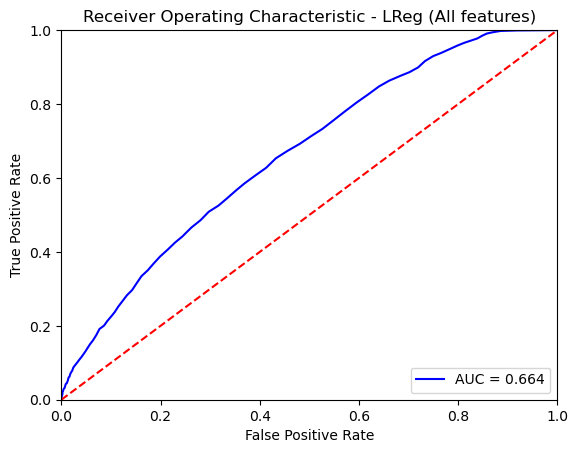

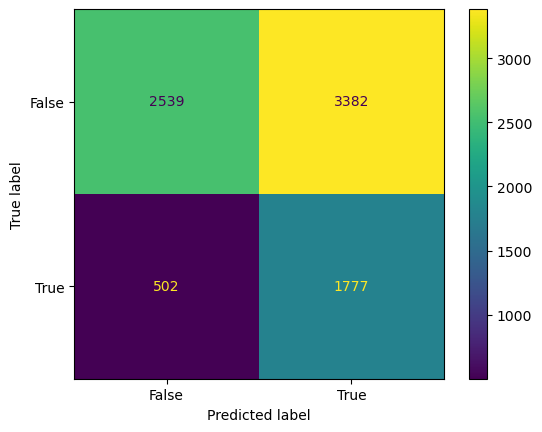

In [179]:
model_3 = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model_3, metrics_3, threshold_3, roc_3 = train_and_optimize_model(
                                                                    model_3,
                                                                    train_x[pi_top_features], train_y,
                                                                    test_x[pi_top_features], test_y,
                                                                    target_tpr
                                                                )

## 10. Modelos sin valores anómalos <a name="10"></a>

**Filtrado de valores anómalos**

In [183]:
is_inlier_everywhere = (is_annual_income_inlier *
                        is_max_credit_inlier *
                        is_monthly_debt_inlier *
                        is_credit_years_inlier *
                        is_number_accounts_inlier *
                        is_credit_balance_inlier
                       )

inliers_df = loans_data[is_inlier_everywhere]
inliers_df.shape[0]

56191

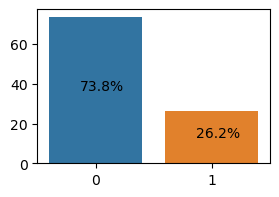

In [184]:
f = 'Loan Status'
plt.figure(figsize=(3, 2))
x_plot = sns.barplot(x=inliers_df[f].value_counts().index,
                    y=inliers_df[f].value_counts().values / inliers_df.shape[0] * 100
           )

for bar in x_plot.patches:
    txt = str(round(bar.get_height(), 1)) + '%'
    bar_w = bar.get_width()
    txt_x = bar.get_x() + bar_w / 3
    txt_y = bar.get_height() / 2
    x_plot.text(txt_x, txt_y, txt)

**Sets de entrenamiento y de prueba**

In [185]:
inlier_x, inlier_y = x[is_inlier_everywhere], y[is_inlier_everywhere]

splits = train_test_split(inlier_x, inlier_y, train_size=0.8, shuffle=True, random_state=1)
train_x, train_y = splits[0], splits[2]
remain_x, remain_y = splits[1], splits[3]

splits = train_test_split(remain_x, remain_y, train_size=0.5, shuffle=True, random_state=1)
test_x, test_y = splits[0], splits[2]
validation_x, validation_y = splits[1], splits[3]

### 10.1. Modelo 4: Bosque Aleatorio <a name="101"></a>

Metricas iniciales:
Exactitud: 74.98%
Precisión: 55.42%
Exhaustividad (TPR): 9.63%
Especificidad: 97.35% (FPR: 2.65%)

Metricas con TPR objetivo:
Umbral: 0.24
Exactitud: 53.87%
Precisión: 33.16%
Exhaustividad (TPR): 79.62%
Especificidad: 45.05% (FPR: 54.95%)


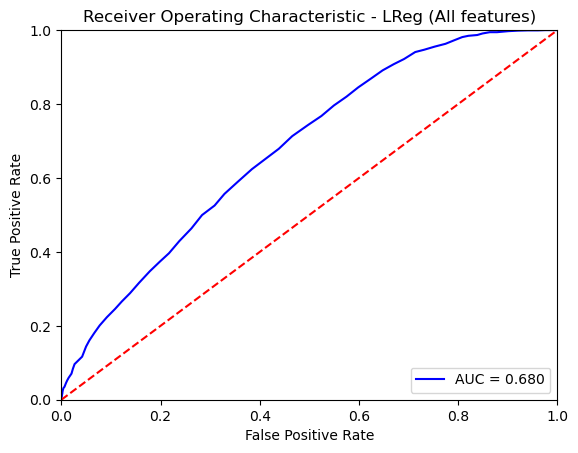

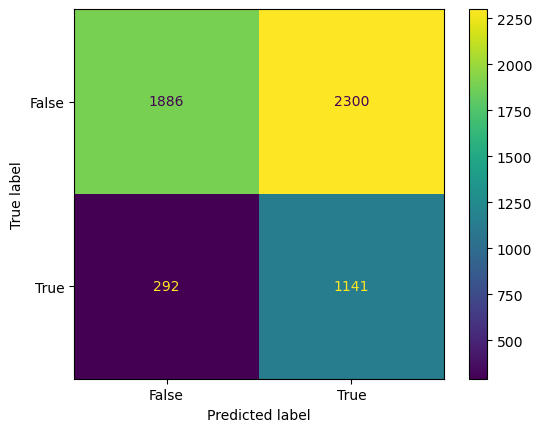

In [186]:
model_4 = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model_4, metrics_4, threshold_4, roc_4 = train_and_optimize_model(
                                                                    model_4,
                                                                    train_x, train_y,
                                                                    test_x, test_y,
                                                                    target_tpr
                                                                )

### 10.2. Modelo 5: Naive Bayes <a name="102"></a>

Metricas iniciales:
Exactitud: 74.14%
Precisión: 47.24%
Exhaustividad (TPR): 11.93%
Especificidad: 95.44% (FPR: 4.56%)

Metricas con TPR objetivo:
Umbral: 0.21103021744045816
Exactitud: 51.98%
Precisión: 31.79%
Exhaustividad (TPR): 77.04%
Especificidad: 43.41% (FPR: 56.59%)


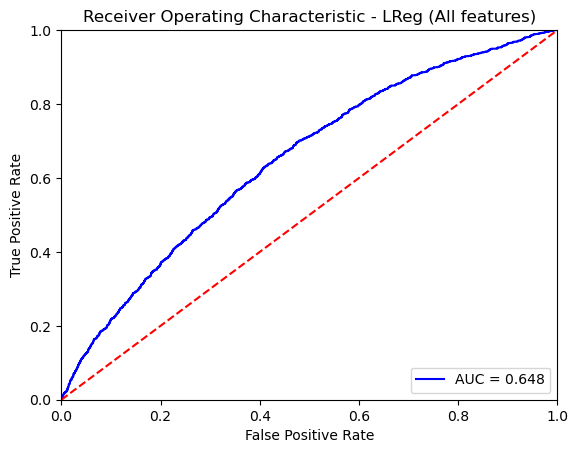

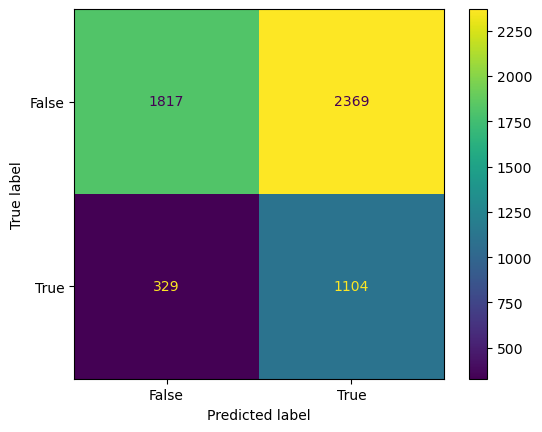

In [188]:
from sklearn.naive_bayes import GaussianNB
model_5, metrics_5, threshold_5, roc_5 = train_and_optimize_model(
                                                                    GaussianNB(),
                                                                    train_x, train_y,
                                                                    test_x, test_y,
                                                                    target_tpr
                                                                )

## 11. Resultados <a name="11"></a>

In [192]:
data = {'Modelo 1': [threshold_1, roc_1] + metrics_1,
        'Modelo 2': [threshold_2, roc_2] + metrics_2,
        'Modelo 3': [threshold_3, roc_3] + metrics_3,
        'Modelo 4': [threshold_4, roc_4] + metrics_4,
        'Modelo 5': [threshold_5, roc_5] + metrics_5,
       }
indexes = ['Threshold', 'AUROC', 'Exactitud', 'Precisión', 'Exhaustividad', 'Especificidad']
summary = pd.DataFrame(data, index=indexes)
summary

,Modelo 1,Modelo 2,Modelo 3,Modelo 4,Modelo 5
Threshold,0.260000,0.250000,0.210000,0.240000,0.211030
AUROC,0.709000,0.699000,0.664000,0.680000,0.648000
Exactitud,58.719512,56.390244,52.634146,53.870796,51.984339
Precisión,38.133047,36.598471,34.444660,33.158965,31.788079
Exhaustividad,77.972795,77.709522,77.972795,79.623168,77.041172
Especificidad,51.308901,48.184428,42.881270,45.054945,43.406593


El mejor modelo es el que tiene el mayor AUROC, que en este caso sería el Modelo 1.

**Validación**

In [181]:
predictions = model_1.predict_proba(validation_x)[:, 1]
predictions[predictions >= threshold_1] = 1
predictions[predictions < threshold_1] = 0

In [182]:
val_metrics = print_metrics(validation_y, predictions)

Exactitud: 57.4%
Precisión: 35.74%
Exhaustividad (TPR): 75.87%
Especificidad: 50.73% (FPR: 49.27%)


**Conclusión**

Se crearon modelos que cumplen con el proposito planteado, tanto si se desean considerar valores anómalos o no. De todos estos, el modelo con el mayor AUC fue el modelo 1, que toma en cuenta todos los predictores y valores. Sin embargo, la estrategia utilizada genera una alta cantidad de falsos positivos (préstamos que en realidad fueron pagados fueron clasificados como impagos). Debe estudiarse los efectos que esto tendría sobre las ganancias de la(s) entida(des) prestamista(s).